# Project description

The goal of this project is to use historical data on game sales to determine a pattern behind if a game will succeed or not. We will be using game data from 2016 to create a hypothetical plan for the year 2017.

We are focusing on a few key questions here. We want to know which platforms are the most popular, and if their popularity is different depending on the region. We also are interested in the popularity in different genres, as well as different ESRB ratings. There are other minor questions that may arise, such as the effect of professional reviews on sales.

Lastly, there are two hypotheses that we are also interested in addressing:

* Average user ratings of the Xbox One and PC platforms are the same.

* Average user ratings for the Action and Sports genres are different.

## Initialization

First we will import our packages and our data set. In case we need to reference unfiltered data after performing operations on our data frame, we will create a copy of the data frame as we import the data.

In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
# import data

games = pd.read_csv('/datasets/games.csv')
og_games = games.copy(deep = False)

### Examine data

Before we get started on working with our questions, we want to get an overhead view to see what the data looks like and how we might need to clean it.

In [3]:
# get info on data frame

games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
# print sample rows

games.head(20)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Getting a look at some of our data, there are a few things that stick out as ways to work with our data. Firstly, most obviously, the Year_of_Release column is a numeric rather than a datetime object - that seems like something we might want to change, but if we think a little further we do not have month or day data. If we had those, we could make some analysis (do games that release on certain days of the week do better? What are the best or worst months to release a game in? etc.) but since we do not have that data then leaving the year of release as a numeric will not cause issues. We also see some missing values in a number of our columns, which we might need to fill in.

Also, for some reason, the user_score column is marked as an object instead of a numerical. We will want to use this column a little later, so we should investigate why that is and fix it to make it into a floating point object.

What is important to note, however, is that the data set also features consoles that would not be actively supported during the time period where we are interested. If we are aiming to create a study on current market trends, it is not necessary to include data for products that are not even in the current market. Luckily, we can use discontinuation data to select consoles on which to focus.

We will want to make a fifth column for sales data, representing the total sales across all regions taken by summing the NA, EU, JP and Other sales.

Finally, something that is not necessary but will make writing code easier would be to change all the column headers to be entirely lower case.

In [5]:
# make columns lower case

games.columns = map(str.lower, games.columns)

In [6]:
# add total sales column

games['total_sales'] = (games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales'])

In [7]:
# check user_score column

games['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.5       2
0.3       2
0.7       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

In [8]:
# replace 'tbd' with null values

games['user_score'] = games['user_score'].replace('tbd',np.NaN)

# convert user_score to numeric

games['user_score'] = pd.to_numeric(games['user_score'])
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
total_sales        16715 non-null float64
dtypes: float64(8), object(4)
memory usage: 1.5+ MB


Now, we can focus on removing unsupported consoles. As of 2016, there were 7 consoles (and PC) that were still being sold, though most of them were not being supported. The primary consoles of 2016 would be the Playstation 4, Xbox One, Nintendo Wii U, and PC. Additionally, the Nintendo 3DS and Playstation Vita were still being sold. While it was a previous generation console the Playstation 3 was not discontinued until 2017, so it could still factor into the data, if necessary. The Xbox 360 was discontinued early in 2016, so we should be more careful about if we want to use it.

We want to choose a time frame that gives us a good amount of data to work with but that also is recent enough that it provides better insight on the current market.

The year between 2014 and 2016 will include a decent amount of releases for previous generation consoles, let's get a look.

In [9]:
# check data frame for games released since 2014

games[games['year_of_release'] >= 2014]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014.0,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
77,FIFA 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16707,Aiyoku no Eustia,PSV,2014.0,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


In [10]:
# see how representation of consoles

games[games['year_of_release'] >= 2014]['platform'].value_counts()

PS4     376
PSV     295
XOne    228
PS3     219
3DS     212
PC      151
X360    111
WiiU     73
PSP      13
Wii      11
Name: platform, dtype: int64

In [11]:
# compare size of games based on release date versus ones of select consoles

consoles = ['PS3', 'PS4', '3DS', 'PC', 'X360', 'XOne', 'WiiU', 'PSV']
games[games['platform'].isin(consoles)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14,Kinect Adventures!,X360,2010.0,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
29,Call of Duty: Modern Warfare 3,X360,2011.0,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
...,...,...,...,...,...,...,...,...,...,...,...,...
16707,Aiyoku no Eustia,PSV,2014.0,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


As we might expect, there are more values by console than there is by year. There are only 2 other consoles represented in the data based on year of release compared to the platform: the PSP (discontinued in 2014), and the Wii (discontinued in 2013-2014 depending on the region).

Since filtering by console gives us data from as long as a decade prior, it will generally be more practical to filter by year. We will get slightly fewer data points that way, but when it comes to analysis on market trends, it will give us more relevant data points.

Before we do so, however, we should address that we have missing values in our release year. Since we are aiming to analyze based on release year, we should try and fill those out first.

Before we manipulate our data frame, however, it might be useful to store the full data frame at this moment.

In [12]:
games_no_miss = games.copy(deep = False)

## Preparing data set

### Missing values in release year

We don't need to interpolate a possible release year, since all of our data has a direct link to an actual game. The simplest way to deal with our missing values, then, is to manually fill in the release year. But we have 269 missing values in that column. Doing it one at a time would be rather difficult.

What we can do, however, is first split our data set based on console. While this is not the final split we will be making, it is one that will prove useful. While our year-based check earlier on did show more consoles than the console based one, there are some consoles that we can definitively count out of our data set.

We can without much controversy remove consoles that had no releases in the previous 3 years from our data set.

In [13]:
# create list of consoles to include

consoles = ['PS3', 'PS4', 'PSP', 'PSV', 'PC', 'X360', 'XOne', 'Wii', 'WiiU', '3DS']

# check number of games with a missing year of release

games[games['platform'].isin(consoles)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7832 entries, 0 to 16714
Data columns (total 12 columns):
name               7832 non-null object
platform           7832 non-null object
year_of_release    7701 non-null float64
genre              7832 non-null object
na_sales           7832 non-null float64
eu_sales           7832 non-null float64
jp_sales           7832 non-null float64
other_sales        7832 non-null float64
critic_score       4297 non-null float64
user_score         4450 non-null float64
rating             5249 non-null object
total_sales        7832 non-null float64
dtypes: float64(8), object(4)
memory usage: 795.4+ KB


If we filter this way, we have only 131 values (roughly 1.7% of this section of the data frame) remaining with a missing year value. Significantly easier to work with, but still not something we necessarily want to deal with manually. We can, however, check to see if those null values have some commonality, such as sales.

In [14]:
# check which consoles in the data frame have a missing release year

print(games[games['platform'].isin(consoles) & games['year_of_release'].isna()]['platform'].value_counts())
games[games['platform'].isin(consoles) & games['year_of_release'].isna()].describe()

Wii     34
X360    30
PS3     25
PC      17
PSP     16
3DS      8
PSV      1
Name: platform, dtype: int64


,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,0.0,131.000000,131.000000,131.000000,131.000000,80.00000,71.000000,131.000000
mean,NaN,0.184427,0.097710,0.022748,0.035191,67.15000,6.847887,0.340076
std,NaN,0.329398,0.178617,0.094112,0.059928,13.91666,1.303935,0.530221
min,NaN,0.000000,0.000000,0.000000,0.000000,28.00000,3.600000,0.010000
25%,NaN,0.000000,0.000000,0.000000,0.000000,58.75000,6.050000,0.050000
50%,NaN,0.070000,0.010000,0.000000,0.010000,70.00000,7.000000,0.150000
75%,NaN,0.180000,0.130000,0.000000,0.040000,77.00000,7.900000,0.375000
max,NaN,1.930000,0.970000,0.770000,0.290000,92.00000,8.900000,3.060000


What we see here is that most of the missing values are for games of the previous generation, as well as ones that are generally lower in sales. Dropping most of these null values would not harm our data set too significantly, but there is a way that we could fill out some of these. If the game has the same title as one on a different platform, we can reasonably assume that it was released in the same year.

In fact, if we are aiming to work on future sales, they may help the data since we would be reducing noise that might be caused by the previous console generation. Thus, we will start cleaning our data by first dropping the values where the year of release is not known.

In [15]:
no_years = games[games['platform'].isin(consoles) & games['name'].duplicated(keep=False)]
no_years = no_years[(no_years['year_of_release'] >= 2014) | (no_years['year_of_release'].isna())]
no_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1236 entries, 31 to 16714
Data columns (total 12 columns):
name               1236 non-null object
platform           1236 non-null object
year_of_release    1148 non-null float64
genre              1236 non-null object
na_sales           1236 non-null float64
eu_sales           1236 non-null float64
jp_sales           1236 non-null float64
other_sales        1236 non-null float64
critic_score       621 non-null float64
user_score         780 non-null float64
rating             845 non-null object
total_sales        1236 non-null float64
dtypes: float64(8), object(4)
memory usage: 125.5+ KB


In [16]:
no_years[no_years['year_of_release'] >= 2014 & no_years['name'].duplicated(keep=False)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1148 entries, 31 to 16714
Data columns (total 12 columns):
name               1148 non-null object
platform           1148 non-null object
year_of_release    1148 non-null float64
genre              1148 non-null object
na_sales           1148 non-null float64
eu_sales           1148 non-null float64
jp_sales           1148 non-null float64
other_sales        1148 non-null float64
critic_score       556 non-null float64
user_score         721 non-null float64
rating             773 non-null object
total_sales        1148 non-null float64
dtypes: float64(8), object(4)
memory usage: 116.6+ KB


We see that we don't have very many titles that we can fill missing release year for, only 88 titles. However, when we checked again, we notice that there is not a single title in the duplicated data frame that was released after 2014 that also had a null value for a title on a different console. This is because we saw that when we filtered the data frame to include "games released after 2014 OR games that had a null release year", we received the same number of non-null release years as we did when we filtered for "games that released after 2014 AND have a name that appears more than once." What this means is that of the duplicated games, the only titles that have null release years are ones that have released prior to 2014.

This reduces the number of titles that we can potentially fill in on our data set to 43. The only way to fill those in accurately would be manually, so instead they will only be dropped.

The other areas where we have missing values to deal with are in the critic score and user score columns, as well as in the rating column. Dealing with these will be tricky. After all, they are data that, by all rights, seems like it is subjective. We could certainly try and manually fill it out, but there should be a better way to do so.

First, let's update our data frame to represent this subset of games released on or after 2014.

### Missing values in scores


While it can't always be said to be accurate, there is the possibility that we could see some sort of correlation between the critic and user scores so that we could in theory use one to fill the other. First, let's see just how strongly correlated the two are.

In [17]:
# check if critic and user scores are correlated with each other

games.corr()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
year_of_release,1.000000,-0.092500,0.003978,-0.168366,0.037820,0.011411,-0.267851,-0.076313
na_sales,-0.092500,1.000000,0.765335,0.449594,0.638649,0.240755,0.086200,0.941017
eu_sales,0.003978,0.765335,1.000000,0.435061,0.722792,0.220752,0.055337,0.901240
jp_sales,-0.168366,0.449594,0.435061,1.000000,0.291089,0.152593,0.125598,0.612289
other_sales,0.037820,0.638649,0.722792,0.291089,1.000000,0.198554,0.057119,0.749260
critic_score,0.011411,0.240755,0.220752,0.152593,0.198554,1.000000,0.580878,0.245507
user_score,-0.267851,0.086200,0.055337,0.125598,0.057119,0.580878,1.000000,0.088179
total_sales,-0.076313,0.941017,0.901240,0.612289,0.749260,0.245507,0.088179,1.000000


We see here that while there is a fairly strong correlation between the critic and user scores, it is still not quite so strong. Do users have a tendency to be more lenient on a game, or more harsh? If we knew that, we could potentially see a pattern that is more usable. We could use some plots to try and figure that out.

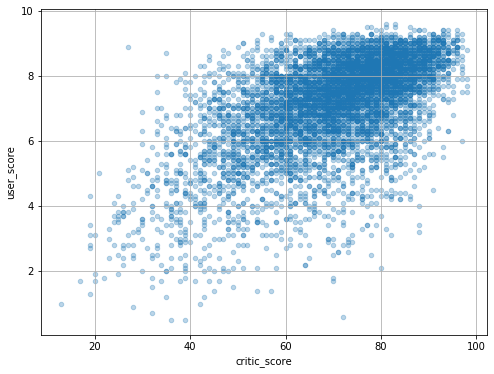

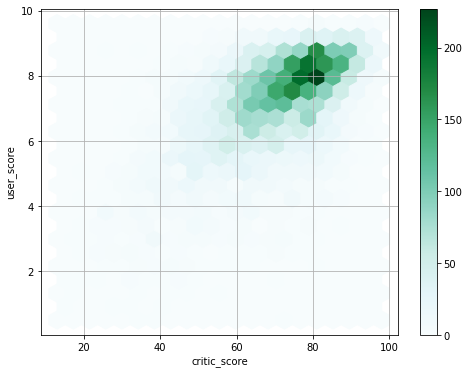

In [18]:
# plot what the correlation looks like

# scatter plot

games.plot(x='critic_score', y='user_score', kind='scatter', figsize=(8, 6), alpha=0.3, grid=True);

# hexagon plot

games.plot(x='critic_score', y='user_score', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True);

We observe that even though there is not a direct one to one correlation between the critic and user scores, there still is a fairly strong correlation between the two. It seems they tend to agree the most when it comes to giving scores of around 8 points. Based on the scatter plot, it would appear that critics do tend to be far more lenient in their scoring. It seems like it is not uncommon for a critic to give a game that had a user score of under 4 points 70 to 90 points, a phoenomena that we do not witness a single time happening the other way around.

With this in mind, it seems like a suitable choice would be to match the user and critic scores in the data set only where they are commonly matching up in our observed data. We see the largest clusters of data are where the critic score is around 60 to 90 points and the user score is around 6 to 9. We, of course, will need to change the scale since the critic scores are measured by an extra factor of 10.

How much of our data set will this affect, though? We not only need to know one column for it to fill in, we also need to not know the other. Many of our scores should already be known for both games - that is how we could make a correlation plot, after all. It might be so few data points that we can fill in with this method that dropping them for accuracy would be better.

In [19]:
# find out how many entries could be filled in under the logic of 60-90% scores matching

print('Where critic score is known and user score is not:')
games[(games['critic_score'] >= 60) & (games['critic_score'] <= 90) &
      (games['user_score'].isna())].info()

print('\nWhere user score is known and critic score is not:')
games[(games['user_score'] >= 6) & (games['user_score'] <= 9) &
      (games['critic_score'].isna())].info()

Where critic score is known and user score is not:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 182 to 16695
Data columns (total 12 columns):
name               647 non-null object
platform           647 non-null object
year_of_release    631 non-null float64
genre              647 non-null object
na_sales           647 non-null float64
eu_sales           647 non-null float64
jp_sales           647 non-null float64
other_sales        647 non-null float64
critic_score       647 non-null float64
user_score         0 non-null float64
rating             636 non-null object
total_sales        647 non-null float64
dtypes: float64(8), object(4)
memory usage: 65.7+ KB

Where user score is known and critic score is not:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 291 to 16681
Data columns (total 12 columns):
name               380 non-null object
platform           380 non-null object
year_of_release    378 non-null float64
genre              380 non-null ob

118 values is not a huge amount in our data set, but it is something that we might want to hold onto if possible. Thus, we will fill in these values.

In [20]:
# fill in missing user scores

for row, index in games.iterrows():
    if (games['critic_score'].loc[row] >= 60) & (games['critic_score'].loc[row] <= 90) & (pd.isnull(games['user_score'].loc[row])):
        games.at[row, 'user_score'] = (games['critic_score'].loc[row] / 10)

# fill in missing critic scores
        
for row, index in games.iterrows():
    if (games['user_score'].loc[row] >= 6) & (games['user_score'].loc[row] <= 9) & (pd.isnull(games['critic_score'].loc[row])):
        games.at[row, 'critic_score'] = (games['user_score'].loc[row] * 10)

In [21]:
# check to see the new data

print('Where critic score is known and user score is not:')
games[(games['critic_score'] >= 60) & (games['critic_score'] <= 90) &
      (games['user_score'].isna())].info()

print('\nWhere user score is known and critic score is not:')
games[(games['user_score'] >= 6) & (games['user_score'] <= 9) &
      (games['critic_score'].isna())].info()

print('\nFull data:')
games.info()

Where critic score is known and user score is not:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 12 columns):
name               0 non-null object
platform           0 non-null object
year_of_release    0 non-null float64
genre              0 non-null object
na_sales           0 non-null float64
eu_sales           0 non-null float64
jp_sales           0 non-null float64
other_sales        0 non-null float64
critic_score       0 non-null float64
user_score         0 non-null float64
rating             0 non-null object
total_sales        0 non-null float64
dtypes: float64(8), object(4)
memory usage: 0.0+ bytes

Where user score is known and critic score is not:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 12 columns):
name               0 non-null object
platform           0 non-null object
year_of_release    0 non-null float64
genre              0 non-null object
na_sales           0 non-null float64
eu_sales         

There is one more thing that we could do to try and address missing values, and that is to see if there are ports with a missing value for one or more of our values. If we have a port with a missing critic score, user score, or rating of a game that has the value represented, we can fill it in with the value we have on a different version of the same game. Whether or not a port was as good at a different release will have to be put aside as we do this.

In [22]:
# check for duplicate games on different platforms

games[games['name'].duplicated(keep=False)]['name'].value_counts()

Need for Speed: Most Wanted                           12
Madden NFL 07                                          9
LEGO Marvel Super Heroes                               9
FIFA 14                                                9
Ratatouille                                            9
                                                      ..
Rugby World Cup 2011                                   2
Megamind: Ultimate Showdown                            2
Midnight Club 3: DUB Edition                           2
Midnight Mysteries: The Edgar Allan Poe Conspiracy     2
Rayman 2: The Great Escape                             2
Name: name, Length: 2805, dtype: int64

We see there are quite a few entries that have many different skews. We should then try and figure out a way to fill out the data here. First, we will make a list of all our duplicated games. This should help us out as we try to fill out the missing values.

In [23]:
# find out how many unique games are missing a value in the data

missing_values = ['critic_score', 'user_score', 'rating']
game_titles = []

for row, index in games[games['name'].duplicated(keep=False)].iterrows():
    for values in missing_values:
        if (pd.isnull(games[values].loc[row])):
            if games['name'].loc[row] not in game_titles:
                game_titles.append(games['name'].loc[row])

len(game_titles)

1483

We have 212 unique games that are missing one of their values on one of their skews. We can do this in a loop, but the question is how we should fill out the score? We could have an issue with trying to decide between a mean or median value, but there is an issue with having a low number of observations. What do we mean by this? Well, it would be easier to take a look at the average amount of times a game appears in the list.

In [24]:
# check average number of times games with the same title appear

games[games['name'].duplicated(keep=False)]['name'].value_counts().describe()

count    2805.000000
mean        2.837433
std         1.219473
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        12.000000
Name: name, dtype: float64

Here we see that for most of the duplicated games, they only will appear 2-3 times in the list. If one of those values is Null (the value we are trying to eliminate) then if we choose the median, we will have a high chance of returning a null value anyway. If we choose to fill the missing values with the mean, however, we will never have this issue.

In [25]:
# fill in missing scores of duplicate games

missing_scores = ['critic_score', 'user_score']

for titles in game_titles:
    games.loc[games['name'] == titles, 'critic_score'] = games[games['name'] == titles]['critic_score'].fillna(
        games[games['name'] == titles]['critic_score'].mean())
    games.loc[games['name'] == titles, 'user_score'] = games[games['name'] == titles]['user_score'].fillna(
        games[games['name'] == titles]['user_score'].mean())

In [26]:
# check data frame

games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       9335 non-null float64
user_score         9111 non-null float64
rating             9949 non-null object
total_sales        16715 non-null float64
dtypes: float64(8), object(4)
memory usage: 1.5+ MB


We have a pretty good increase in data as a result of this. We could potentially fill out the rating data, but as a categorical that will be rather troubling to attempt. We have 969 critic scores and 983 user scores.

Even with that, we do not have a great access to the full score data. We do have two questions to address based on our data: the popularity of games based on the scores they are given, and the popularity of the games based on their ESRB rating.  If we have too many missing values, they might cause some unseen issues.

We can create three separate data frames to work within. One will be a data frame of only the points where we have access to the critic score (there are more rows with user score values - those are because we only saw a similarity in user and critic scores where the scores were between 60 and 90%). The second data frame will be only for those entries where the ESRB rating is known. The third, primary data frame we will work in, will be all of the entries.

To reiterate, we could in theory try and interpolate the missing values but it would either be essentially guessing (in the case of critic and user scores) or require manually adding which would require looking up the games with missing values, one at a time, and adding a line of code for each single one.

### Creating separate data frames

In [27]:
# create scored_games data frame

scored_games = games.copy(deep = False)
scored_games = scored_games.drop('rating', axis = 1)
scored_games = scored_games.dropna()
scored_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8852 entries, 0 to 16706
Data columns (total 11 columns):
name               8852 non-null object
platform           8852 non-null object
year_of_release    8852 non-null float64
genre              8852 non-null object
na_sales           8852 non-null float64
eu_sales           8852 non-null float64
jp_sales           8852 non-null float64
other_sales        8852 non-null float64
critic_score       8852 non-null float64
user_score         8852 non-null float64
total_sales        8852 non-null float64
dtypes: float64(8), object(3)
memory usage: 829.9+ KB


In [28]:
# create rated_games info

rated_games = games.copy(deep = False)
rated_games = rated_games.drop(['critic_score', 'user_score'], axis = 1)
rated_games = rated_games.dropna()
rated_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9768 entries, 0 to 16706
Data columns (total 10 columns):
name               9768 non-null object
platform           9768 non-null object
year_of_release    9768 non-null float64
genre              9768 non-null object
na_sales           9768 non-null float64
eu_sales           9768 non-null float64
jp_sales           9768 non-null float64
other_sales        9768 non-null float64
rating             9768 non-null object
total_sales        9768 non-null float64
dtypes: float64(6), object(4)
memory usage: 839.4+ KB


## Study popularity of consoles

There are a few different ways to find which consoles are the most popular. First, let's get some basic data about what the data looks like. Specifically, how often each console is represented in our data.

In [29]:
# see how often each console appears in the data

games['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
GB        98
NES       98
DC        52
GEN       29
NG        12
WS         6
SCD        6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

This gives us a general example how how often the consoles have appeared in our data, in order of most common to least common. However, it is also possible that some consoles might have mega-hits that give them the highest amount of sales as a whole while others have more numerous, smaller hits. We will take a look at the total game sales that each console has, as well.

In order to get a refresher on what potential factors can be used as a predictor of sales, we can take a look at our correlation matrix. This time, we should make sure that we make notes as to which factors are the most highly correlated.

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
year_of_release,1.000000,-0.092500,0.003978,-0.168366,0.037820,0.016560,-0.242192,-0.076313
na_sales,-0.092500,1.000000,0.765335,0.449594,0.638649,0.227322,0.094382,0.941017
eu_sales,0.003978,0.765335,1.000000,0.435061,0.722792,0.209594,0.063831,0.901240
jp_sales,-0.168366,0.449594,0.435061,1.000000,0.291089,0.147613,0.132769,0.612289
other_sales,0.037820,0.638649,0.722792,0.291089,1.000000,0.189645,0.063854,0.749260
critic_score,0.016560,0.227322,0.209594,0.147613,0.189645,1.000000,0.577094,0.233874
user_score,-0.242192,0.094382,0.063831,0.132769,0.063854,0.577094,1.000000,0.097601
total_sales,-0.076313,0.941017,0.901240,0.612289,0.749260,0.233874,0.097601,1.000000


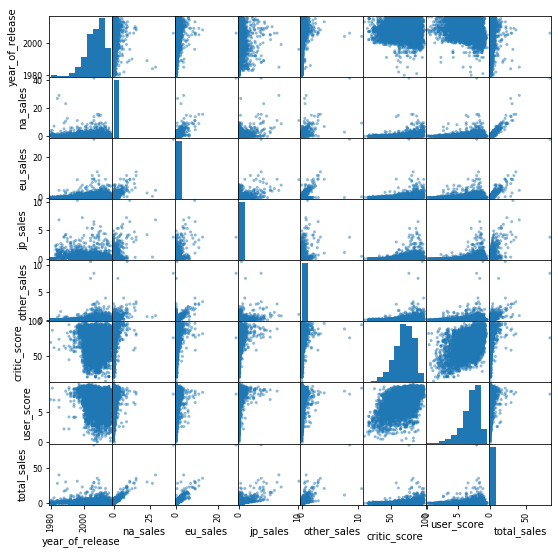

In [30]:
# plot correlations

pd.plotting.scatter_matrix(games, figsize=(9, 9))

games.corr()

The factor we are most interested in is the last row of our correlation matrix, the total_sales. We see a few things that we can note:

1. The sales per year appear to be mostly consistent, without any year standing out as being much larger than the others

2. The NA, EU, and Other region sales are, predictably, very highly correlated with the total sales. However, the Japanese sales, while they are highly correlated, are not nearly as strongly as the others. The Japanese sales have a much weaker correlation with the sales figures of other regions. This suggests that the Japanese market is noticeably different from the other regions.

3. The critic score is strongly correlated with the total sales, creating a parabola. The user score, however, is rather weakly correlated with sales.

4. The total sales are slightly lower in 2016. This may be attributed due to a poor year, a transition to new consoles, or perhaps simply that people have had more time to purchase releases from 2015 and 2014.

### Determining how to rank popularity of consoles

In [31]:
# check statistics of sales by console

print('Grouped Data:')
games.groupby(['platform']).agg({'total_sales' : ('count','sum', 'mean', 'median')}).reset_index()

Grouped Data:


platform total_sales                          
                  count      sum      mean median
0      2600         133    96.98  0.729173  0.460
1       3DO           3     0.10  0.033333  0.020
2       3DS         520   259.00  0.498077  0.120
3        DC          52    15.95  0.306731  0.135
4        DS        2151   806.12  0.374765  0.110
5        GB          98   255.46  2.606735  1.165
6       GBA         822   317.85  0.386679  0.160
7        GC         556   198.93  0.357788  0.150
8       GEN          29    30.77  1.061034  0.150
9        GG           1     0.04  0.040000  0.040
10      N64         319   218.68  0.685517  0.270
11      NES          98   251.05  2.561735  1.375
12       NG          12     1.44  0.120000  0.100
13       PC         974   259.52  0.266448  0.050
14     PCFX           1     0.03  0.030000  0.030
15       PS        1197   730.86  0.610576  0.260
16      PS2        2161  1255.77  0.581106  0.230
17      PS3        1331   939.65  0.705973  0.270
18      PS4         392   314.14  0.801378  0.200
19      PSP        1209   294.05  0.243218  0.090
20      PSV         430    54.07  0.125744  0.055
21      SAT         173    33.59  0.194162  0.120
22      SCD           6     1.86  0.310000  0.065
23     SNES         239   200.04  0.836987  0.320
24     TG16           2     0.16  0.080000  0.080
25       WS           6     1.42  0.236667  0.215
26      Wii        1320   907.51  0.687508  0.190
27     WiiU         147    82.19  0.559116  0.220
28     X360        1262   971.42  0.769746  0.280
29       XB         824   257.74  0.312791  0.150
30     XOne         247   159.32  0.645020  0.220

These columns all tell us something different. The "count" of sales tells us simply how many games appear in the data set, whereas the "sum" tells us how many games were sold in total. This is different in the sense that, for instance, we see that the PS Vita has 295 games, far more than the PC, but the PC's sum sales of 27.05 compared to the Vita's 22.40 means that even though they have fewer games represented, the ones that they do have in our data ended up selling more units.

The mean and median columns similarly can give us an overhead view of whether the games would average selling more. For instance, the XBox 360 has far fewer values compared to the PS3, but their mean and median sales being higher show that their games have, on average, more big hits.

We can get a better idea of this by looking over the descriptive statistics.

In [32]:
# check variance

sales_variance = pd.DataFrame()

for console in consoles:
    temp_var = np.var(games[games['platform'] == console]['total_sales'])
    sales_variance.at[console, 'variance'] = temp_var

sales_variance

,variance
PS3,1.935511
PS4,2.583741
PSP,0.270395
PSV,0.044921
PC,0.455936
X360,2.608335
XOne,1.069237
Wii,9.768275
WiiU,1.113506
3DS,2.043469


We see here that for some consoles we have an incredibly small variance - the PSP and PS Vita are the smallest. But for others, we have extremely large variance. This means that the sales of games on some consoles can be reliably consistent, whereas on others they tend to be extremely spread out.

There are some reasons why this could be the case, but the most simple one would be that there is a general benchmark that most games in our data set reach and that consoles that see greater success have more games that could be considered "hits" that sell significantly higher than the mean (which would make the variance larger). 

To visualize this point, let's take a look at a box plot of the sales by console. We will also display the mean value of sales.

#### Box plot

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


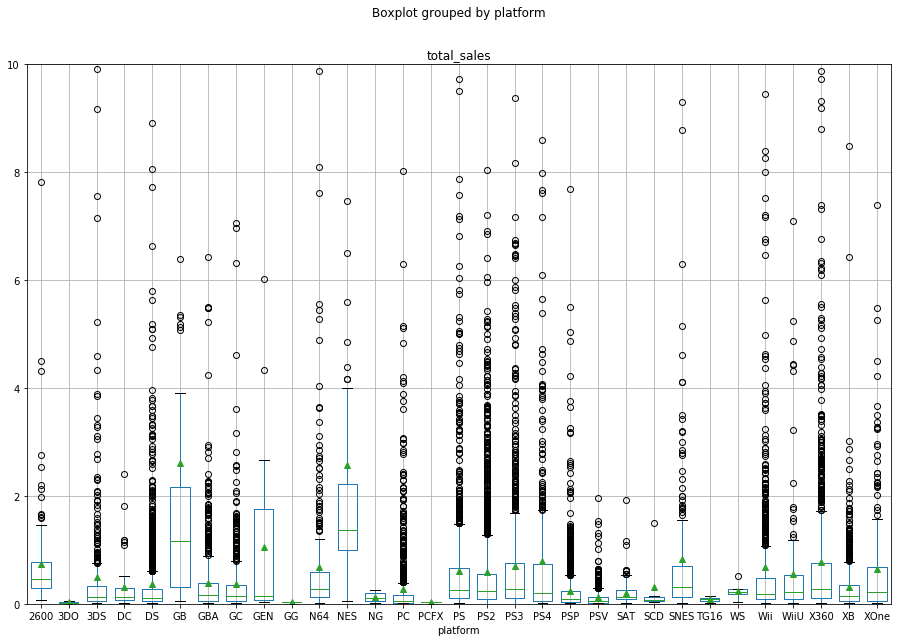

In [33]:
games.boxplot(column = 'total_sales', by = 'platform', showmeans = True, figsize = (15,10), widths = 0.7);
plt.ylim([0,10]);

As we see here, there is a certain amount of weight we can give a console on the total sales they have achieved. Their median values are fairly close and could be potentially used to gauge which one had "on average" the best sales.

We also see that the handheld consoles universally have averages that are significantly lower than the other consoles, and this likely is a result of them tending to have lower prices. The 3DS, as we see in our earlier Grouped Data table, shows that it has significantly higher sales than the Wii U, but for this metric, it suggests the 3DS as the less popular console because the average revenue is lower.

Regardless of whether we choose the mean or the median, some consoles will benefit and others will be handicapped. However, it is not an accurate metric if the sales prices between games based on the platform differs. Most consoles standardize to a \\$60 price tag, but handhelds tended to retail at \\$40, and digital-only games (such as on the PC) have always been cheaper. For this reason, we will not be using the price as a metric for popularity of consoles.

This leads us into explaining exactly how we could create a ranking of consoles. We will be creating a multi-tiered system of rankings where we take each metric and add them up, then put the consoles in order of how they have performed.

For instance, we will reference the following two data frames, sorting the values we have found earlier:

In [34]:
# print data for explanation

games.groupby(['platform']).agg({'total_sales' : ('count')}).sort_values(by = 'total_sales', ascending=False).reset_index()

,platform,total_sales
0,PS2,2161
1,DS,2151
2,PS3,1331
3,Wii,1320
4,X360,1262
5,PSP,1209
6,PS,1197
7,PC,974
8,XB,824
9,GBA,822


In this case, we will assign the PS4 a score of 10, the Vita a 9, the XBox One 8, etc. We will do the same for the sum of total sales.

### Assigning metrics scores to rank popularity

In [35]:
# create functions to generate scores

def plat_count_score(metric):
    score_data = games.groupby(['platform']).agg({metric : ('count')}).sort_values(
        by = metric, ascending=False).reset_index()
    score_data.insert(loc = 2, column = 'sales_score', value = 10)
    for row, index in score_data.iterrows():
        score_data['sales_score'][row] -= row
    return score_data

def plat_sum_score(metric):
    score_data = games.groupby(['platform']).agg({metric : ('sum')}).sort_values(
        by = metric, ascending=False).reset_index()
    score_data.insert(loc = 2, column = 'sum_score', value = 10)
    for row, index in score_data.iterrows():
        score_data['sum_score'][row] -= row
    return score_data

In [36]:
# create data to store the ranked scores

plat_score_dataset = pd.DataFrame({'platform': consoles})

# total popularity

plat_count = plat_count_score('total_sales')
plat_sum = plat_sum_score('total_sales')

plat_score_dataset = plat_score_dataset.merge(plat_count, on= 'platform', how = 'inner')
plat_score_dataset = plat_score_dataset.merge(plat_sum, on= 'platform', how = 'inner')

# drop irrelevant columns

plat_score_dataset = plat_score_dataset.drop(['total_sales_x', 'total_sales_y'], axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [37]:
plat_score_dataset

,platform,sales_score,sum_score
0,PS3,8,8
1,PS4,-3,3
2,PSP,5,2
3,PSV,-2,-10
4,PC,3,1
5,X360,6,9
6,XOne,-5,-7
7,Wii,7,7
8,WiiU,-8,-9
9,3DS,-1,0


We can see for instance that our score at the moment has PS4 at the top with a total score of 20. We will add a few more metrics to try and get a more accurate judgment using this method.

The next metric will be the general look at what people think of a platform's game quality. We can also get a check on how highly rated the platform's games are both among users and critics by taking a look at the average scores given. Since these will simply be the review ratings the games were given, there is not any 

In [38]:
# check average user/critic scores

scored_games.groupby(['platform']).agg({'critic_score' : ('mean','median'), 'user_score': ('mean', 'median')}).reset_index()

platform critic_score            user_score       
                    mean     median       mean median
0      2600    72.611111  69.333333   7.700000  7.100
1       3DS    68.435632  70.000000   6.843042  7.100
2        DC    84.781250  86.000000   8.337500  8.700
3        DS    65.735073  68.000000   6.895181  7.000
4        GB    81.416667  85.000000   8.720833  9.050
5       GBA    68.858770  71.000000   7.377809  7.600
6        GC    69.738574  70.000000   7.441710  7.800
7       GEN    67.416667  73.250000   6.647222  7.575
8       N64    73.982407  75.000000   7.511481  7.600
9       NES    72.583333  74.000000   7.825000  8.000
10       PC    76.049699  78.000000   7.086105  7.500
11       PS    73.532875  76.000000   7.732148  8.100
12      PS2    69.277370  70.000000   7.532509  7.800
13      PS3    70.568644  73.000000   6.725499  7.100
14      PS4    72.757759  75.000000   6.823190  7.100
15      PSP    68.518340  69.000000   7.146407  7.300
16      PSV    71.363254  72.000000   7.320301  7.600
17      SAT    75.555556  78.000000   7.761111  8.200
18     SNES    76.303571  77.000000   8.005357  8.500
19      Wii    64.371848  66.000000   6.780755  7.000
20     WiiU    70.931052  73.000000   7.046825  7.350
21     X360    69.078499  72.000000   6.701782  7.000
22       XB    70.617358  72.000000   7.427539  7.700
23     XOne    73.983010  76.000000   6.606270  6.800

In this case, the averages between mean and median scores do not appear so vastly different that they should be both counted. It would be essentially multiplying the weight we are giving this metric. Our first metric was "how many different titles are in our data set," the second was "how many total sales does the console's games have", so this third one will be only "how well received were the games?" Similar to how we did not want to measure the profits since that would be placing more emphasis on the total sales, we should not account for the rating multiple times.

So there are one of four metrics that we can choose to use for our ratings metric: the critic mean, the critic median, the user mean, or the user median. Since the medians have many overlapping data points, those will not be used. The critic score is arguably not relevant for the measure of popularity (and the user score is more highly correlated with sales, as we saw earlier), as the users are the ones who are more representative of the general public. So we will use the user mean.

In [39]:
# create average user score

plat_rating_avg = scored_games.groupby(['platform']).agg({'user_score' : ('mean')}).sort_values(
    by = 'user_score', ascending=False).reset_index()
plat_rating_avg.insert(loc = 2, column = 'rating_avg', value = 10)
for row, index in plat_rating_avg.iterrows():
    plat_rating_avg['rating_avg'][row] -= row
    
# merge onto data

plat_score_dataset = plat_score_dataset.merge(plat_rating_avg, on= 'platform', how = 'inner')
plat_score_dataset = plat_score_dataset.drop(['user_score'], axis = 1)
plat_score_dataset

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,platform,sales_score,sum_score,rating_avg
0,PS3,8,8,-10
1,PS4,-3,3,-8
2,PSP,5,2,-3
3,PSV,-2,-10,-2
4,PC,3,1,-4
5,X360,6,9,-11
6,XOne,-5,-7,-13
7,Wii,7,7,-9
8,WiiU,-8,-9,-5
9,3DS,-1,0,-7


### Popularity ranking in full

,platform,sales_score,sum_score,rating_avg,total_score
0,PS3,8,8,-10,6
1,Wii,7,7,-9,5
2,PSP,5,2,-3,4
3,X360,6,9,-11,4
4,PC,3,1,-4,0
5,PS4,-3,3,-8,-8
6,3DS,-1,0,-7,-8
7,PSV,-2,-10,-2,-14
8,WiiU,-8,-9,-5,-22
9,XOne,-5,-7,-13,-25


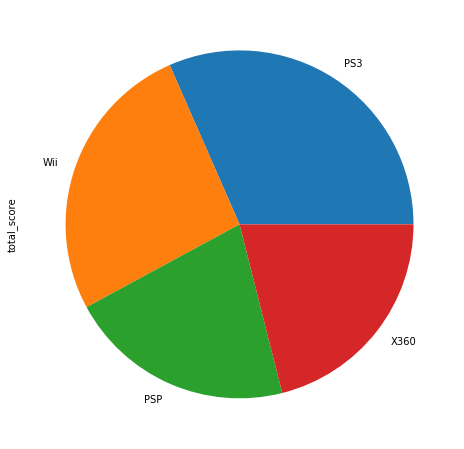

In [40]:
# create total score

plat_score_dataset['total_score'] = (plat_score_dataset['sales_score'] + plat_score_dataset['sum_score'] + 
                                     plat_score_dataset['rating_avg']
)
total_platform_score = plat_score_dataset.sort_values(by = 'total_score', ascending=False).reset_index(drop = True)

# display ranking

total_platform_score.iloc[0:5].plot(
    x = 'platform', y = 'total_score', kind = 'pie', labels = total_platform_score.iloc[0:5]['platform'], 
    legend = None, figsize = (16,8));
total_platform_score

On a global level, we see our ranking of the most popular consoles of the years 2011-2016. In order, most to least popular: PS4, XBox One, PS Vita, 3DS, PS3, Wii U, PSP, PC, XBox 360, Wii.

This seems to make sense. The consoles that were being supported through the most recent years are higher in the ranking. The current generation consoles are performing better than their prior iterations. The PS4 and XBox One released in 2013 and 2014, respectively, so their predecesors were seeing some support through 2014 to 2016.

### Console popularity by region

Sinces values we calculated earlier are simply the total number of times that the item has appeared in the data set, taking it into account by region will bias the data. It tells us the games that appeared somewhere on the data set, but it does not say anything about how well they did in a specific region. The only data that we have that is region specific is the sales data. If we use the sales_score or rating_avg values we calculated earlier, they will bias the data with values that might be from other regions.

The conclusions here will be far less robust than the full data set, but may be worthwhile to get, anyway.

In [41]:
# create a data set to merge onto

na_score_dataset = pd.DataFrame({'platform': consoles})

# rank popularity

na_sum = plat_sum_score('na_sales')

na_score_dataset = na_score_dataset.merge(na_sum, on= 'platform', how = 'inner')
na_score_dataset.columns = ['platform', 'sales', 'na_score']

na_ranking = na_score_dataset.sort_values(by = 'na_score', ascending=False).reset_index(drop = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


NA console ranking: 


,platform,sales,na_score
0,X360,602.47,10
1,Wii,496.90,8
2,PS3,393.49,7
3,PSP,109.17,-2
4,PS4,108.74,-3
5,PC,94.53,-4
6,XOne,93.12,-5
7,3DS,83.49,-7
8,WiiU,38.10,-9
9,PSV,12.58,-11


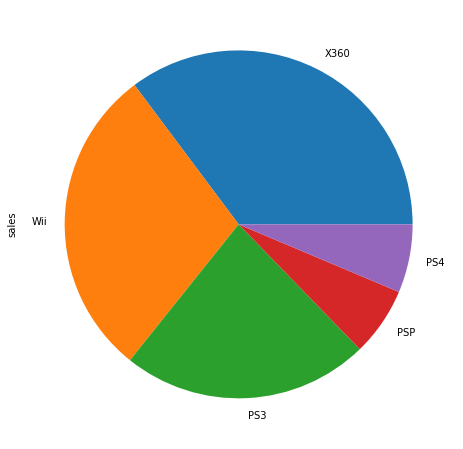

In [42]:
print("NA console ranking: ")
na_ranking.iloc[0:5].plot(
    x = 'platform', y = 'sales', kind = 'pie', labels = na_ranking.iloc[0:5]['platform'], legend = None, figsize = (16,8));
na_ranking

In [43]:
# create a data set to merge onto

eu_score_dataset = pd.DataFrame({'platform': consoles})

# rank popularity

eu_sum = plat_sum_score('eu_sales')

eu_score_dataset = eu_score_dataset.merge(eu_sum, on= 'platform', how = 'inner')
eu_score_dataset.columns = ['platform', 'sales', 'eu_score']

eu_ranking = eu_score_dataset.sort_values(by = 'eu_score', ascending=False).reset_index(drop = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


EU console ranking: 


,platform,sales,eu_score
0,PS3,330.29,9
1,X360,270.76,8
2,Wii,262.21,7
3,PC,142.44,4
4,PS4,141.09,3
5,PSP,66.68,1
6,3DS,61.48,0
7,XOne,51.59,-2
8,WiiU,25.13,-6
9,PSV,13.12,-9


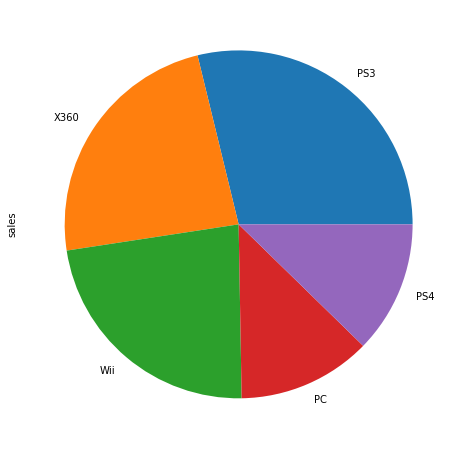

In [44]:
print("EU console ranking: ")
eu_ranking.iloc[0:5].plot(
    x = 'platform', y = 'sales', kind = 'pie', labels = eu_ranking.iloc[0:5]['platform'], legend = None, figsize = (16,8));
eu_ranking

In [45]:
# create a data set to merge onto

jp_score_dataset = pd.DataFrame({'platform': consoles})

# rank popularity

jp_sum = plat_sum_score('jp_sales')

jp_score_dataset = jp_score_dataset.merge(jp_sum, on= 'platform', how = 'inner')
jp_score_dataset.columns = ['platform', 'sales', 'jp_score']

jp_ranking = jp_score_dataset.sort_values(by = 'jp_score', ascending=False).reset_index(drop = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


JP console ranking: 


,platform,sales,jp_score
0,3DS,100.67,6
1,PS3,80.19,3
2,PSP,76.78,2
3,Wii,69.33,1
4,PSV,21.91,-3
5,PS4,15.96,-5
6,WiiU,13.01,-6
7,X360,12.43,-7
8,XOne,0.34,-14
9,PC,0.17,-15


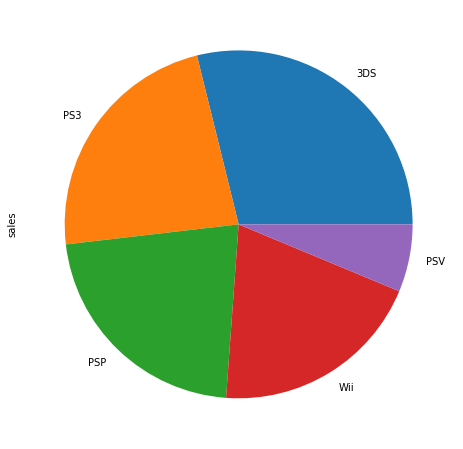

In [46]:
print("JP console ranking: ")
jp_ranking.iloc[0:5].plot(
    x = 'platform', y = 'sales', kind = 'pie', labels = jp_ranking.iloc[0:5]['platform'], legend = None, figsize = (16,8));
jp_ranking

In [47]:
# create a data set to merge onto

other_score_dataset = pd.DataFrame({'platform': consoles})

# rank popularity

other_sum = plat_sum_score('other_sales')

other_score_dataset = other_score_dataset.merge(other_sum, on= 'platform', how = 'inner')
other_score_dataset.columns = ['platform', 'sales', 'other_score']

other_ranking = other_score_dataset.sort_values(by = 'other_score', ascending=False).reset_index(drop = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Other regions console ranking: 


,platform,sales,other_score
0,PS3,135.68,9
1,X360,85.76,8
2,Wii,79.07,7
3,PS4,48.35,5
4,PSP,41.42,4
5,PC,22.38,2
6,XOne,14.27,1
7,3DS,13.36,0
8,PSV,6.46,-4
9,WiiU,5.95,-5


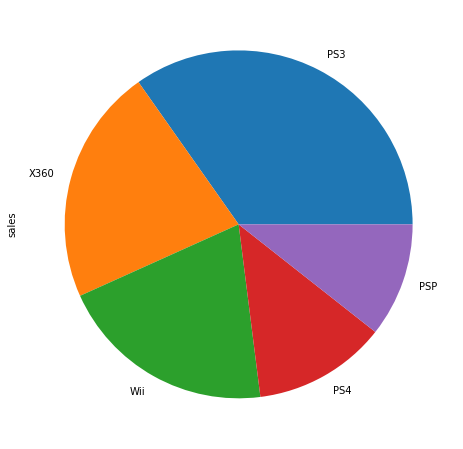

In [48]:
print("Other regions console ranking: ")
other_ranking.iloc[0:5].plot(
    x = 'platform', y = 'sales', kind = 'pie', 
    labels = other_ranking.iloc[0:5]['platform'], legend = None, figsize = (16,8));
other_ranking

The top 5 consoles by region:

NA: PS4, XBox One, XBox 360, 3DS, PS3

EU: PS4, XBox One, PS3, PC, 3DS

JP: 3DS, PS4, PS Vita, PS3, Wii U

Other regions: PS4, XBox One, PS3, XBox 360, 3DS

All regions: PS4, XBox One, PS Vita, 3DS, PS3

### Console popularity conclusions

We see that the PS3, PS4, and 3DS are the only consoles represented across all the regions' top five. Japan appears more fond of handhelds, with the 3DS, PSP, and Vita all being represented in their top 5. The XBox consoles are more popular in the North America region, and the PC was doing well in Europe and in other regions, but not so well in North America or Japan. However, based on sales alone we see that the PS4 is incredibly dominant.

Interestingly, despite the Vita being extremely low across all regions except Japan, it is in the top 5 for the total data set. The key factor here is that it had the best rating average, which might indicate that, perhaps, it had games that were simply highly appealing to the Japanese audience, who left enough positive reviews to raise the average.

PC is getting fairly close to all the consoles, but is still lagging behind. It has a low rating average, which might mean a few things. A high volume of shovelware? Our data is not using that, so that cannot be the reason. Most likely, it is that PC gamers are different from console gamers, perhaps more likely to be more critical in their reviews, or leave none at all. Or perhaps it is simply that the convenience of a console makes it generally more alluring to people.

We can gather the information on these and place them onto a single bar chart to get a better visualization based on region. Since we have the total_score variable that is using multiple metrics we will divide it by 2 so that it will be on a similar scale 

In [49]:
full_console_data = total_platform_score.merge(na_ranking, on= 'platform', how = 'inner')
full_console_data = full_console_data.merge(eu_ranking, on= 'platform', how = 'inner')
full_console_data = full_console_data.merge(jp_ranking, on= 'platform', how = 'inner')
full_console_data = full_console_data.merge(other_ranking, on= 'platform', how = 'inner')
full_console_data['adjusted_score']  = full_console_data['total_score']/2

full_console_data

,platform,sales_score,sum_score,rating_avg,total_score,sales_x,na_score,sales_y,eu_score,sales_x,jp_score,sales_y,other_score,adjusted_score
0,PS3,8,8,-10,6,393.49,7,330.29,9,80.19,3,135.68,9,3.0
1,Wii,7,7,-9,5,496.90,8,262.21,7,69.33,1,79.07,7,2.5
2,PSP,5,2,-3,4,109.17,-2,66.68,1,76.78,2,41.42,4,2.0
3,X360,6,9,-11,4,602.47,10,270.76,8,12.43,-7,85.76,8,2.0
4,PC,3,1,-4,0,94.53,-4,142.44,4,0.17,-15,22.38,2,0.0
5,PS4,-3,3,-8,-8,108.74,-3,141.09,3,15.96,-5,48.35,5,-4.0
6,3DS,-1,0,-7,-8,83.49,-7,61.48,0,100.67,6,13.36,0,-4.0
7,PSV,-2,-10,-2,-14,12.58,-11,13.12,-9,21.91,-3,6.46,-4,-7.0
8,WiiU,-8,-9,-5,-22,38.10,-9,25.13,-6,13.01,-6,5.95,-5,-11.0
9,XOne,-5,-7,-13,-25,93.12,-5,51.59,-2,0.34,-14,14.27,1,-12.5


### Plotted console popularity rank

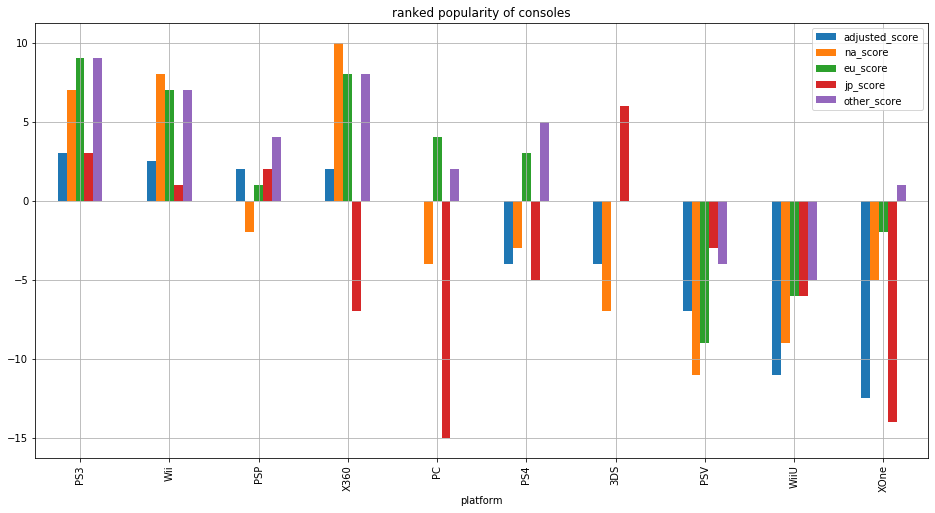

In [50]:
full_console_data.plot(
    x = 'platform', y = ['adjusted_score', 'na_score', 'eu_score', 'jp_score', 'other_score'], kind = 'bar', 
    title = 'ranked popularity of consoles', grid = True, figsize = (16,8));

## Study popularity of genres

Similarly to what we did with the popularity of the consoles, we could likely do the same to discern the popularity of different game genres.

### Choosing metrics

In [51]:
# get a look at data

print('Grouped Data:')
games.groupby(['genre']).agg({'total_sales' : ('count','sum', 'mean', 'median')}).reset_index()

Grouped Data:


genre total_sales                          
                       count      sum      mean median
0         Action        3369  1744.17  0.517711   0.19
1      Adventure        1303   237.59  0.182341   0.05
2       Fighting         849   447.53  0.527126   0.21
3           Misc        1750   802.51  0.458577   0.16
4       Platform         888   827.77  0.932173   0.27
5         Puzzle         580   242.57  0.418224   0.11
6         Racing        1249   728.67  0.583403   0.19
7   Role-Playing        1498   934.56  0.623872   0.18
8        Shooter        1323  1052.45  0.795503   0.24
9     Simulation         873   389.97  0.446701   0.15
10        Sports        2348  1331.27  0.566980   0.22
11      Strategy         683   174.23  0.255095   0.10

Here we can see some troubling points. "Action," "Role-Playing," "Adventure," and "Misc" are rather vague as far as genre titles go. But there is not much we can do about it. We can only hope that the data won't be quite so important, but as it stands we can say that likely we won't be able to draw quite as strong judgments based on this segment.

One thing that we can say for certain: Shooters, platformers, and sports titles, despite being less represented than other genres, seem to sell really well. Shooter has the highest mean and median of sales, followed by platformers at the second highest mean (though sports has the second highest median). Yet role-playing games, despite selling less than sports games, make more money.

Here, we have a bit of a question about if we should use the average sales as a metric. We did not use it in our console popularity metric since different sales prices were clearly having an effect on the average revenue gained. The numbers based on genre don't appear to have that problem, so they could plausibly use sales as a popularity metric. To determine whether we could use mean or median, perhaps a box plot examination could help.

In [52]:
# check variance

genre_variance = pd.DataFrame()
genres = games['genre'].unique()

for genre in genres:
    temp_var = np.var(games[games['genre'] == genre]['total_sales'])
    genre_variance.at[genre, 'variance'] = temp_var

genre_variance

,variance
Sports,4.344449
Platform,6.620617
Racing,2.742132
Role-Playing,2.922755
Puzzle,2.437022
Misc,1.701100
Shooter,3.296904
Simulation,1.406929
Action,1.312002
Fighting,0.905814


The variance of the shooting genre is troubling. There are, like the console metrics, a wide spread of variances. This time, they appear to be more stable overall but they still are so wildly different that the mean most likely is not a metric we want to use.

#### Box plot

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


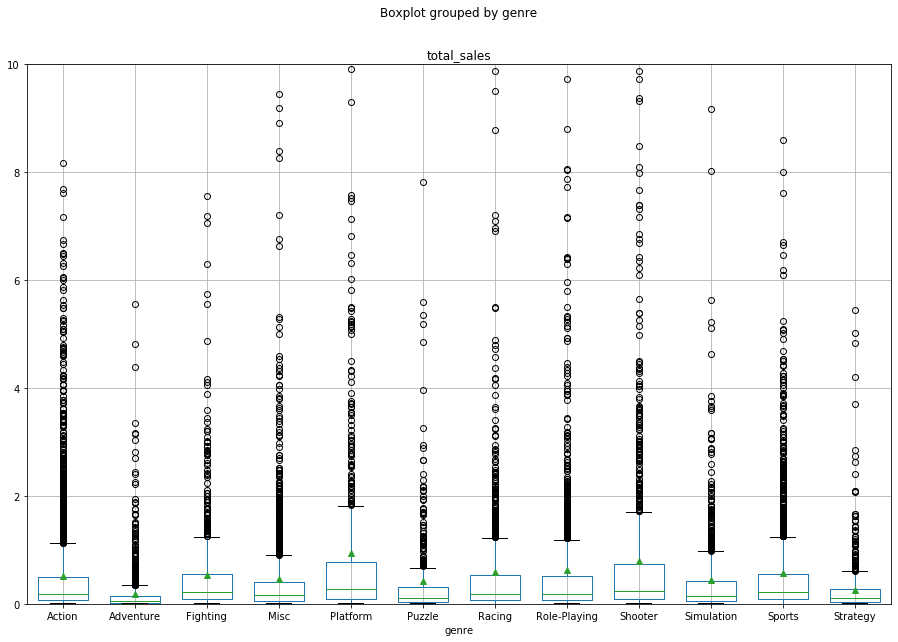

In [53]:
games.boxplot(column = 'total_sales', by = 'genre', showmeans = True, figsize = (15,10), widths = 0.7);
plt.ylim([0,10]);

Some of our games have far more outliers than others. This could be simply because we saw that puzzle games, strategy games, and simulation games were some of our least common. The choice, ultimately, requires that instead of looking at the raw data that perhaps we should think about it from a practical standpoint.

What would high outliers in the genre mean, specifically, about the genre's popularity? For instance, in that "Fighting" entry. There, we see a value that is well beyond all the others, having sold nearly \\$8,000,000 worth of units, when most of the entries, even outliers, don't break \\$2,000,000. This does not necessarily mean that all fighting games are popular, but that one specific fighting game is incredibly popular. As a whole, platformers tend to be more popular than fighting games, although none are quite as popular as that one.

What that means for us is that the median values would probably be better to use as our metric for average sales used to gauge the genre's popularity. That would be an easier way to find out which genres sell more on average, rather than ones that might have a few huge hits.

We can create functions to calculate these scores, and perform a similar operation to how we found the most popular consoles. Since we have 12 genres to work with, we will use 11 as our maximum score.

#### Create functions to assign metrics

In [54]:
# write functions for count, sum, and median sales

def genre_count(metric):
    score_data = games.groupby(['genre']).agg({metric : ('count')}).sort_values(
        by = metric, ascending=False).reset_index()
    score_data.insert(loc = 2, column = 'sales_score', value = 11)
    for row, index in score_data.iterrows():
        score_data['sales_score'][row] -= row
    return score_data

def genre_sum(metric):
    score_data = games.groupby(['genre']).agg({metric : ('sum')}).sort_values(
        by = metric, ascending=False).reset_index()
    score_data.insert(loc = 2, column = 'sum_score', value = 11)
    for row, index in score_data.iterrows():
        score_data['sum_score'][row] -= row
    return score_data

def genre_median(metric):
    score_data = games.groupby(['genre']).agg({metric : ('median')}).sort_values(
        by = metric, ascending=False).reset_index()
    score_data.insert(loc = 2, column = 'median_score', value = 11)
    for row, index in score_data.iterrows():
        score_data['median_score'][row] -= row
    return score_data

# we can create the average user rating here, to use later. 

genre_rating_avg = scored_games.groupby(['genre']).agg({'user_score' : ('mean')}).sort_values(
    by = 'user_score', ascending=False).reset_index()
genre_rating_avg.insert(loc = 2, column = 'rating_avg', value = 11)
for row, index in genre_rating_avg.iterrows():
    genre_rating_avg['rating_avg'][row] -= row

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [55]:
# check the user rating rank

genre_rating_avg

,genre,user_score,rating_avg
0,Role-Playing,7.618364,11
1,Strategy,7.292857,10
2,Fighting,7.265049,9
3,Platform,7.213390,8
4,Puzzle,7.127451,7
5,Simulation,7.115328,6
6,Racing,7.067386,5
7,Adventure,7.031063,4
8,Shooter,7.029432,3
9,Action,7.028227,2


### Create genre popularity ranking

In [56]:
# create a data set to merge onto

genres = games['genre'].unique()

total_genre_score = pd.DataFrame({'genre': genres})

# total popularity

total_genre_count = genre_count('total_sales')
total_genre_sum = genre_sum('total_sales')
total_genre_median = genre_median('total_sales')

total_genre_score = total_genre_score.merge(total_genre_count, on= 'genre', how = 'inner')
total_genre_score = total_genre_score.merge(total_genre_sum, on= 'genre', how = 'inner')
total_genre_score = total_genre_score.merge(total_genre_median, on= 'genre', how = 'inner')
total_genre_score = total_genre_score.merge(genre_rating_avg, on= 'genre', how = 'inner')

# drop irrelevant columns

total_genre_score = total_genre_score.drop(['total_sales_x', 'total_sales', 'user_score'], axis = 1)

# create total score

total_genre_score['total_score'] = (total_genre_score['sales_score'] + total_genre_score['sum_score'] + 
                                    total_genre_score['median_score'] + total_genre_score['rating_avg']
                                   )
total_genre_ranking = total_genre_score.sort_values(by = 'total_score', ascending=False).reset_index(drop = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Genres ranked by popularity:


,genre,sales_score,total_sales_y,sum_score,median_score,rating_avg,total_score
0,Role-Playing,8,934.56,8,5,11,32
1,Action,11,1744.17,11,7,2,31
2,Sports,10,1331.27,10,9,1,30
3,Platform,4,827.77,7,11,8,30
4,Shooter,7,1052.45,9,10,3,29
5,Fighting,2,447.53,4,8,9,23
6,Racing,5,728.67,5,6,5,21
7,Misc,9,802.51,6,4,0,19
8,Simulation,3,389.97,3,3,6,15
9,Strategy,1,174.23,0,1,10,12


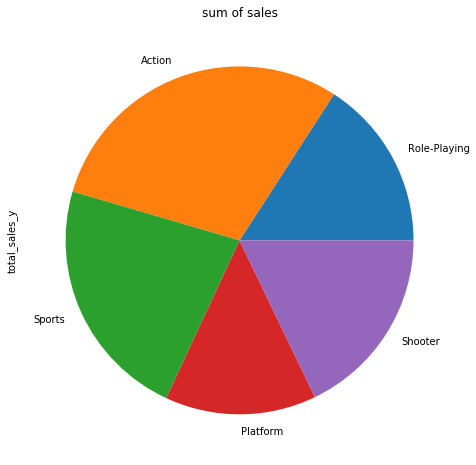

In [57]:
print("Genres ranked by popularity:")
total_genre_ranking.iloc[0:5].plot(
    x = 'genre', y = 'total_sales_y', title = 'sum of sales', kind = 'pie', 
    labels = total_genre_ranking.iloc[0:5]['genre'], legend = None, figsize = (16,8));
total_genre_ranking

Here we see some of the world of the gaming industry in simple numbers. The sales numbers and reception show some results that gives us a good feel for both how games generally sell compared to how users think of them, and what sort of environment we can expect from them.

Take for instance, how the puzzle genre has the third highest rating average among all users, despite being one of the worst selling genres. That tells us that not many people buy puzzle games, but the ones who do really enjoy them. Adventure is another genre that gives us something about the industry, having the second highest rating while having the lowest median sales - what this seems to suggest is that the genre is too saturated and there are many games classed as "adventure" that sell poorly - though with it having the third highest number of entries, that only makes sense.

Pretty much every one of our genres can be analyzed in such a way. But for our purposes, we can look at a few things. If we are just analyzing which genres sell the best, we could have stopped earlier but in terms of what is popular with the consumer base, it would be role playing games, action games, shooters, sports games, and platformers. Well, people leaving user reviews don't seem to enjoy sports games, but let's put that aside for now and get our ratings by region.

### Genre popularity by region

Similarly to how we removed a couple data points from the earlier analysis because they were not region-specific, we should remove it from our analysis here. However, we can use two metrics this time around. Since our data is based on the sales data, we can use both the sum and median. The number of games in each genre and the average genre rating should not be included, however.

In [58]:
# create a data set to merge onto

na_genre_score = pd.DataFrame({'genre': genres})

# total popularity

na_sum = genre_sum('na_sales')
na_median = genre_median('na_sales')

na_genre_score = na_genre_score.merge(na_sum, on= 'genre', how = 'inner')
na_genre_score = na_genre_score.merge(na_median, on= 'genre', how = 'inner')

# create total score

na_genre_score['na_score'] = (na_genre_score['sum_score'] + na_genre_score['median_score'])
na_genre_ranking = na_genre_score.sort_values(by = 'na_score', ascending=False).reset_index(drop = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Genres ranked by popularity in NA:


,genre,na_sales_x,sum_score,na_sales_y,median_score,na_score
0,Sports,684.43,10,0.11,9,19
1,Platform,445.50,8,0.14,11,19
2,Shooter,592.24,9,0.12,10,19
3,Action,879.01,11,0.10,8,19
4,Racing,359.35,6,0.10,7,13
5,Misc,407.27,7,0.08,5,12
6,Fighting,223.36,4,0.08,6,10
7,Role-Playing,330.81,5,0.04,2,7
8,Simulation,181.92,3,0.07,4,7
9,Puzzle,122.87,2,0.05,3,5


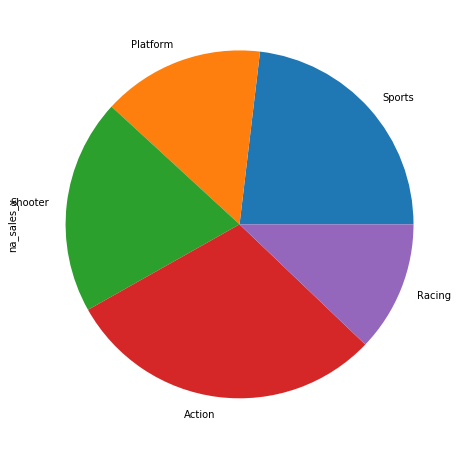

In [59]:
print("Genres ranked by popularity in NA:")
na_genre_ranking.iloc[0:5].plot(
    x = 'genre', y = 'na_sales_x', kind = 'pie', 
    labels = na_genre_ranking.iloc[0:5]['genre'], legend = None, figsize = (16,8));
na_genre_ranking

In [60]:
# create a data set to merge onto

eu_genre_score = pd.DataFrame({'genre': genres})

# total popularity

eu_sum = genre_sum('eu_sales')
eu_median = genre_median('eu_sales')

eu_genre_score = eu_genre_score.merge(eu_sum, on= 'genre', how = 'inner')
eu_genre_score = eu_genre_score.merge(eu_median, on= 'genre', how = 'inner')

# create total score

eu_genre_score['eu_score'] = (eu_genre_score['sum_score'] + eu_genre_score['median_score'])
eu_genre_ranking = eu_genre_score.sort_values(by = 'eu_score', ascending=False).reset_index(drop = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Genres ranked by popularity in EU:


,genre,eu_sales_x,sum_score,eu_sales_y,median_score,eu_score
0,Shooter,317.34,9,0.05,10,19
1,Action,519.13,11,0.03,8,19
2,Platform,200.35,6,0.05,11,17
3,Racing,236.51,8,0.04,9,17
4,Sports,376.79,10,0.02,6,16
5,Misc,212.74,7,0.01,5,12
6,Fighting,100.33,3,0.02,7,10
7,Role-Playing,188.71,5,0.01,3,8
8,Simulation,113.52,4,0.01,2,6
9,Puzzle,50.01,1,0.01,4,5


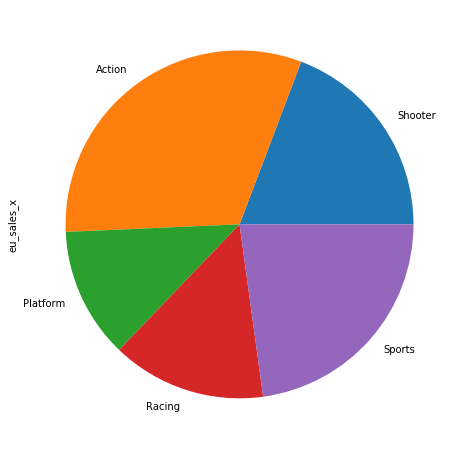

In [61]:
print("Genres ranked by popularity in EU:")
eu_genre_ranking.iloc[0:5].plot(
    x = 'genre', y = 'eu_sales_x', kind = 'pie', 
    labels = eu_genre_ranking.iloc[0:5]['genre'], legend = None, figsize = (16,8));
eu_genre_ranking

In [62]:
# create a data set to merge onto

jp_genre_score = pd.DataFrame({'genre': genres})

# total popularity

jp_sum = genre_sum('jp_sales')
jp_median = genre_median('jp_sales')

jp_genre_score = jp_genre_score.merge(jp_sum, on= 'genre', how = 'inner')
jp_genre_score = jp_genre_score.merge(jp_median, on= 'genre', how = 'inner')

# create total score

jp_genre_score['jp_score'] = (jp_genre_score['sum_score'] + jp_genre_score['median_score'])
jp_genre_ranking = jp_genre_score.sort_values(by = 'jp_score', ascending=False).reset_index(drop = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Genres ranked by popularity in JP:


,genre,jp_sales_x,sum_score,jp_sales_y,median_score,jp_score
0,Role-Playing,355.41,11,0.05,11,22
1,Action,161.43,10,0.00,8,18
2,Fighting,87.48,6,0.02,10,16
3,Platform,130.83,8,0.00,6,14
4,Misc,108.11,7,0.00,7,14
5,Adventure,52.30,2,0.01,9,11
6,Sports,135.54,9,0.00,1,10
7,Puzzle,57.31,4,0.00,5,9
8,Racing,56.71,3,0.00,4,7
9,Simulation,63.80,5,0.00,2,7


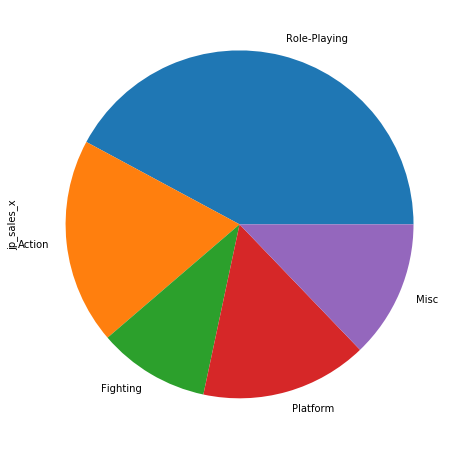

In [63]:
print("Genres ranked by popularity in JP:")
jp_genre_ranking.iloc[0:5].plot(
    x = 'genre', y = 'jp_sales_x', kind = 'pie', 
    labels = jp_genre_ranking.iloc[0:5]['genre'], legend = None, figsize = (16,8));
jp_genre_ranking

In [64]:
# create a data set to merge onto

other_genre_score = pd.DataFrame({'genre': genres})

# total popularity

other_sum = genre_sum('other_sales')
other_median = genre_median('other_sales')

other_genre_score = other_genre_score.merge(other_sum, on= 'genre', how = 'inner')
other_genre_score = other_genre_score.merge(other_median, on= 'genre', how = 'inner')

# create total score

other_genre_score['other_score'] = (other_genre_score['sum_score'] + other_genre_score['median_score'])
other_genre_ranking = other_genre_score.sort_values(by = 'other_score', ascending=False).reset_index(drop = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Genres ranked by popularity in other regions:


,genre,other_sales_x,sum_score,other_sales_y,median_score,other_score
0,Action,184.60,11,0.01,10,21
1,Shooter,104.11,9,0.02,11,20
2,Misc,74.39,7,0.01,8,15
3,Racing,76.10,8,0.01,5,13
4,Fighting,36.36,4,0.01,9,13
5,Sports,134.51,10,0.01,2,12
6,Platform,51.09,5,0.01,7,12
7,Role-Playing,59.63,6,0.01,4,10
8,Puzzle,12.38,1,0.01,6,7
9,Simulation,30.73,3,0.01,3,6


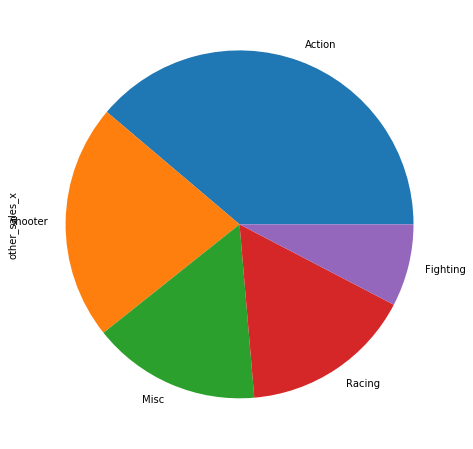

In [65]:
print("Genres ranked by popularity in other regions:")
other_genre_ranking.iloc[0:5].plot(
    x = 'genre', y = 'other_sales_x', kind = 'pie', 
    labels = other_genre_ranking.iloc[0:5]['genre'], legend = None, figsize = (16,8));
other_genre_ranking

The top five genres by region:

NA: Shooter, Sports, Action, Role-Playing, Fighting

EU: Shooter, Action, Sports, Racing, Platform

JP: Role-Playing, Fighting, Action, Misc, Adventure

Other: Shooter, Action, Sports, Role-Playing, Platform

All Regions: Role-Playing, Action, Shooter, Sports, Fighting

### Genre popularity conclusions

Similarly to the popularity by console, the region is fairly similar in the popularity of different genres, with Japan being th exception. Across all regions, the only genre that is always in the top five is "Action," and that likely could be since it covers such a wide range of games. Shooters, Platform games, and Sports appear in all regions outside of Japan, and Platform games are ranked 6 in Japan.

The rankings also involving median scores seems like a useful means of keeping a pulse on the community of gamers. While there are some genres that have gotten a leg up thanks to having a high review score or a high median sales, they don't on aggregate represent the large majority of sales. For instance, fighting games are fairly common to see in the top genres, but their sales are usually comparable to racing games, which are only considered a "top" genre in Europe.

As a whole, the best bet on the "most popular" genre in terms of sales and worldwide scope would be the "Action," game, but it depends on how much one cares to appeal to the JP market.

We will do the same as the console ranking and create a bar chart to visualize these results. 

In [66]:
full_genre_data = total_genre_ranking.merge(na_genre_ranking, on= 'genre', how = 'inner')
full_genre_data = full_genre_data.merge(eu_genre_ranking, on= 'genre', how = 'inner')
full_genre_data = full_genre_data.merge(jp_genre_ranking, on= 'genre', how = 'inner')
full_genre_data = full_genre_data.merge(other_genre_ranking, on= 'genre', how = 'inner')

full_genre_data

,genre,sales_score,total_sales_y,sum_score_x,median_score_x,rating_avg,total_score,na_sales_x,sum_score_y,na_sales_y,...,jp_sales_x,sum_score_y,jp_sales_y,median_score_y,jp_score,other_sales_x,sum_score,other_sales_y,median_score,other_score
0,Role-Playing,8,934.56,8,5,11,32,330.81,5,0.04,...,355.41,11,0.05,11,22,59.63,6,0.01,4,10
1,Action,11,1744.17,11,7,2,31,879.01,11,0.10,...,161.43,10,0.00,8,18,184.60,11,0.01,10,21
2,Sports,10,1331.27,10,9,1,30,684.43,10,0.11,...,135.54,9,0.00,1,10,134.51,10,0.01,2,12
3,Platform,4,827.77,7,11,8,30,445.50,8,0.14,...,130.83,8,0.00,6,14,51.09,5,0.01,7,12
4,Shooter,7,1052.45,9,10,3,29,592.24,9,0.12,...,38.76,0,0.00,3,3,104.11,9,0.02,11,20
5,Fighting,2,447.53,4,8,9,23,223.36,4,0.08,...,87.48,6,0.02,10,16,36.36,4,0.01,9,13
6,Racing,5,728.67,5,6,5,21,359.35,6,0.10,...,56.71,3,0.00,4,7,76.10,8,0.01,5,13
7,Misc,9,802.51,6,4,0,19,407.27,7,0.08,...,108.11,7,0.00,7,14,74.39,7,0.01,8,15
8,Simulation,3,389.97,3,3,6,15,181.92,3,0.07,...,63.80,5,0.00,2,7,30.73,3,0.01,3,6
9,Strategy,1,174.23,0,1,10,12,68.55,0,0.00,...,49.66,1,0.00,0,1,10.85,0,0.00,0,0


### Plotted genre popularity rank

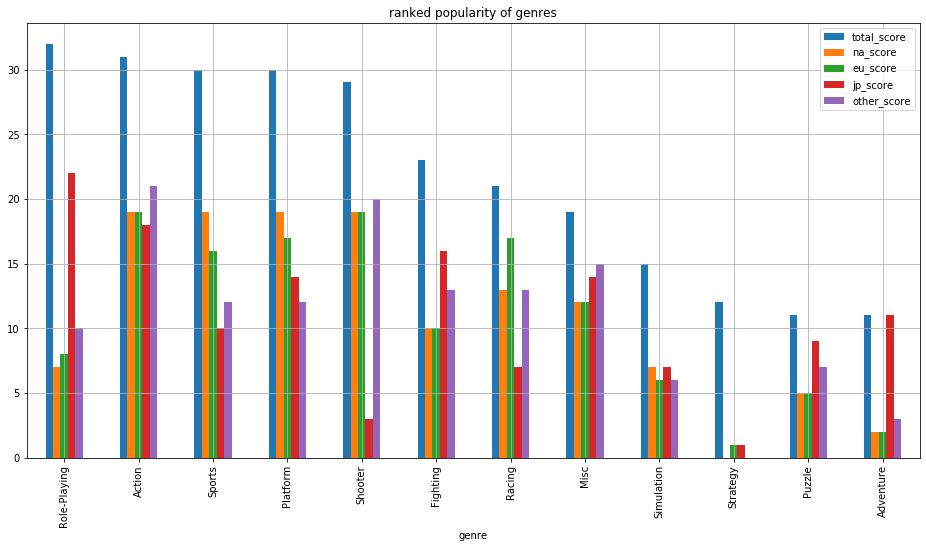

In [67]:
full_genre_data.plot(
    x = 'genre', y = ['total_score', 'na_score', 'eu_score', 'jp_score', 'other_score'], kind = 'bar', 
    title = 'ranked popularity of genres', grid = True, figsize = (16,8));

Next, we will find out if the ESRB rating is an indicator for a game's popularity.

## Study popularity of games by rating

There is one thing to address, before we check our data based on rating that is important to keep in mind. We split our data earlier, and one of those data sets is all the data with ESRB ratings. This will be the data set we work within.

### Choosing metrics

In [68]:
print('Grouped Data:')
rated_games.groupby(['rating']).agg({'total_sales' : ('count','sum', 'mean', 'median')}).reset_index()

Grouped Data:


rating total_sales                          
               count      sum      mean median
0     AO           1     1.96  1.960000   1.96
1      E        3921  2407.61  0.614030   0.20
2   E10+        1393   640.98  0.460144   0.20
3     EC           8     1.75  0.218750   0.22
4    K-A           3     4.32  1.440000   1.91
5      M        1536  1462.53  0.952168   0.31
6     RP           1     0.04  0.040000   0.04
7      T        2905  1473.08  0.507084   0.20

Here we see what appears to be some fairly clear-cut points, but it will be useful to go in depth, regardless. Something else that we might want to consider is grouping together games rated E and E10+ into a blanket "E" rating. However, there are a significant amount of E10+ games, and they do have some distinctions.

In [69]:
# check variance

rating_variance = pd.DataFrame()
esrb = rated_games['rating'].unique()

for rating in esrb:
    temp_var = np.var(rated_games[rated_games['rating'] == rating]['total_sales'])
    rating_variance.at[rating, 'variance'] = temp_var

rating_variance

,variance
E,4.600515
M,3.768803
T,0.836833
E10+,0.636598
K-A,1.062467
AO,0.000000
EC,0.019311
RP,0.000000


Not only do we see that the variance for M rated games is the highest, there is a more key thing we can examine here, and that is that overall it seems like there is a pattern. It appears that the more titles an ESRB rating has, the higher its variance. However, the T and E rantings have the exact same number of titles, but a much different variance. Is this indicating that T rated games tend to have more consistent scores while E rated games vary more wildly in user reaction, or does it mean that E rated games have more games with high user scores?

#### Box plot

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


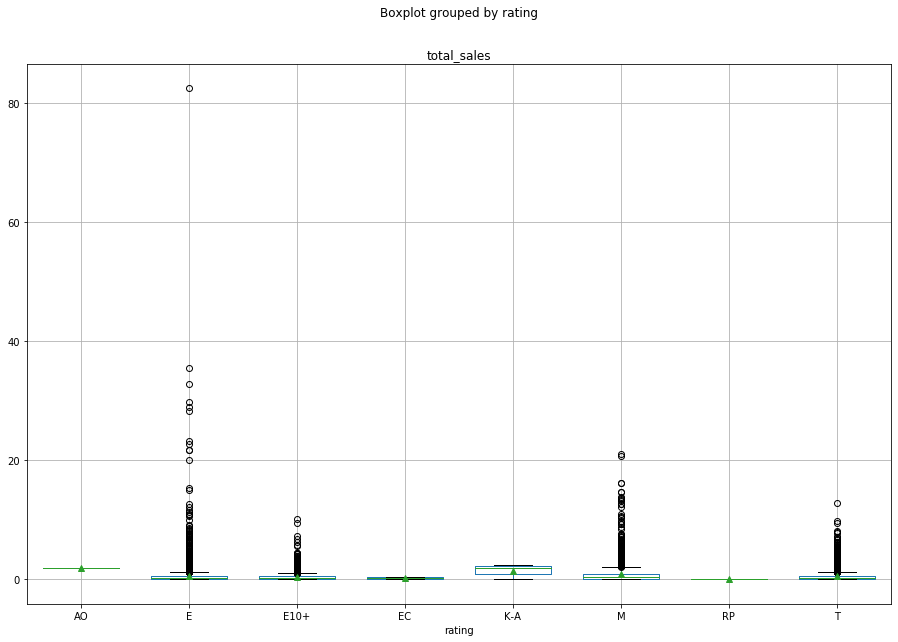

In [70]:
rated_games.boxplot(column = 'total_sales', by = 'rating', showmeans = True, figsize = (15,10), widths = 0.7);

The difference in variance between E and T games seems to actually indicate that E rated games have more games with high user scores, both in general as well as represented in their outliers.

In this case, it seems like the distribution of values is actually about the same. It could be argued that perhaps the mean would not be a bad choice of ranking. However, there is not really any reason to do so. In this specific case, all it will do is be the difference between switching the position of the E and E10+ ratings (as we see above). We will use the median for this metric.

#### Create functions to assign metrics

In [71]:
def rating_count_score(metric):
    score_data = rated_games.groupby(['rating']).agg({metric : ('count')}).sort_values(
        by = metric, ascending=False).reset_index()
    score_data.insert(loc = 2, column = 'count_score', value = 4)
    for row, index in score_data.iterrows():
        score_data['count_score'][row] -= row
    return score_data

def rating_sum_score(metric):
    score_data = rated_games.groupby(['rating']).agg({metric : ('sum')}).sort_values(
        by = metric, ascending=False).reset_index()
    score_data.insert(loc = 2, column = 'sum_score', value = 4)
    for row, index in score_data.iterrows():
        score_data['sum_score'][row] -= row
    return score_data

def rating_median_score(metric):
    score_data = rated_games.groupby(['rating']).agg({metric : ('median')}).sort_values(
        by = metric, ascending=False).reset_index()
    score_data.insert(loc = 2, column = 'median_score', value = 4)
    for row, index in score_data.iterrows():
        score_data['median_score'][row] -= row
    return score_data

### Create rating popularity ranking

In [72]:
# create a data set to merge onto

ratings = rated_games['rating'].unique()

total_rating_score = pd.DataFrame({'rating': ratings})

# total popularity

rating_count = rating_count_score('total_sales')
rating_sum = rating_sum_score('total_sales')
rating_median = rating_median_score('total_sales')

total_rating_score = total_rating_score.merge(rating_count, on= 'rating', how = 'inner')
total_rating_score = total_rating_score.merge(rating_sum, on= 'rating', how = 'inner')
total_rating_score = total_rating_score.merge(rating_median, on= 'rating', how = 'inner')

# drop irrelevant columns

total_rating_score = total_rating_score.drop(['total_sales_x', 'total_sales'], axis = 1)

# create total score

total_rating_score['total_score'] = (total_rating_score['count_score'] + total_rating_score['sum_score'] + 
                                    total_rating_score['median_score']
                                   )
total_rating_ranking = total_rating_score.sort_values(by = 'total_score', ascending=False).reset_index(drop = True)

total_rating_ranking

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,rating,count_score,total_sales_y,sum_score,median_score,total_score
0,E,4,2407.61,4,0,8
1,M,2,1462.53,2,2,6
2,T,3,1473.08,3,-2,4
3,K-A,-1,4.32,0,3,2
4,E10+,1,640.98,1,-1,1
5,AO,-2,1.96,-1,4,1
6,EC,0,1.75,-2,1,-1
7,RP,-3,0.04,-3,-3,-9


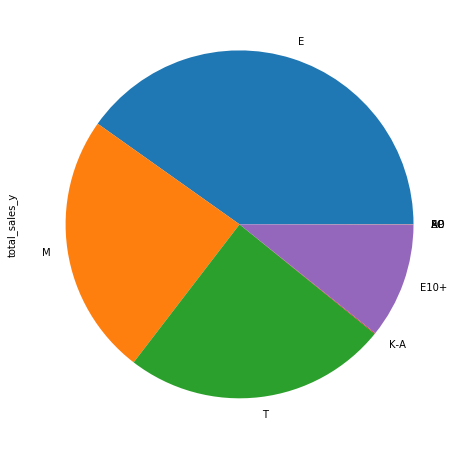

In [73]:
total_rating_ranking.plot(
    x = 'rating', y = 'total_sales_y', kind = 'pie', 
    labels = total_rating_ranking['rating'], legend = None, figsize = (16,8));

The results are pretty consistent, that across all metrics the M rated games are doing the best, with E rated games doing just as well. While M rated games can be called the most popular, and they dominate the majority of the income gained, each genre is incredibly similarly represented in the pie chart. As a whole, it seems that the rating does not have much impact on overall revenue.

Generally, it doesn't seem like there is as much we can parse from these sorts of analyses. If we are speaking about the target demographic for games, we should consider a few things. While T is considered appropriate for teenagers, in terms of marketing that doesn't necessarily mean that they are the target demographic. Some would probably think that M is still the target for teenagers. The same goes for the E and E10+ games, they often are suitable for young audiences but especially for something such as a Nintendo product, their goal is to be family-friendly so their demographic would include older audiences.

If we were to add together the two E ratings, their average revenue would surpass M. This isn't to say they're more popular, just to note that in terms of what makes the most money, a rating of E or E10+ could be on a similar level to M. Though as a whole, we do see that M rated games are still the most successful. Is it true across all regions, however?

### Rating popularity by region

Like we did earlier in the genre-based analysis, we will only use the sales metrics, analyzing the total revenue and the median revenue.

In [74]:
# create a data set to merge onto

na_rating_score = pd.DataFrame({'rating': ratings})

# total popularity

na_sum = rating_sum_score('na_sales')
na_median = rating_median_score('na_sales')

na_rating_score = na_rating_score.merge(na_sum, on= 'rating', how = 'inner')
na_rating_score = na_rating_score.merge(na_median, on= 'rating', how = 'inner')

# drop irrelevant columns

na_rating_score = na_rating_score.drop(['na_sales_y'], axis = 1)

# create total score

na_rating_score['na_score'] = (na_rating_score['sum_score'] + na_rating_score['median_score'])
na_rating_ranking = na_rating_score.sort_values(by = 'na_score', ascending=False).reset_index(drop = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ESRB ratings ranked by popularity in NA:


,rating,na_sales_x,sum_score,median_score,na_score
0,E,1274.24,4,0,4
1,M,742.89,2,1,3
2,K-A,2.56,0,3,3
3,AO,1.26,-2,4,2
4,T,747.60,3,-2,1
5,EC,1.53,-1,2,1
6,E10+,345.50,1,-1,0
7,RP,0.00,-3,-3,-6


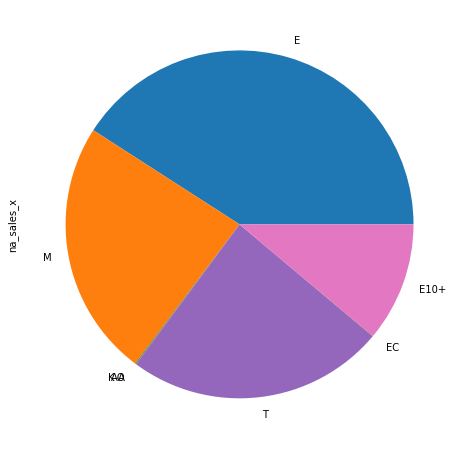

In [75]:
print("ESRB ratings ranked by popularity in NA:")
na_rating_ranking.plot(
    x = 'rating', y = 'na_sales_x', kind = 'pie', 
    labels = na_rating_ranking['rating'], legend = None, figsize = (16,8));
na_rating_ranking

In [76]:
# create a data set to merge onto

eu_rating_score = pd.DataFrame({'rating': ratings})

# total popularity

eu_sum = rating_sum_score('eu_sales')
eu_median = rating_median_score('eu_sales')

eu_rating_score = eu_rating_score.merge(eu_sum, on= 'rating', how = 'inner')
eu_rating_score = eu_rating_score.merge(eu_median, on= 'rating', how = 'inner')

# drop irrelevant columns

eu_rating_score = eu_rating_score.drop(['eu_sales_y'], axis = 1)

# create total score

eu_rating_score['eu_score'] = (eu_rating_score['sum_score'] + eu_rating_score['median_score'])
eu_rating_ranking = eu_rating_score.sort_values(by = 'eu_score', ascending=False).reset_index(drop = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ESRB ratings ranked by popularity in EU:


,rating,eu_sales_x,sum_score,median_score,eu_score
0,M,480.00,3,2,5
1,E,703.87,4,0,4
2,AO,0.61,0,4,4
3,T,421.79,2,1,3
4,K-A,0.27,-1,3,2
5,E10+,183.35,1,-1,0
6,EC,0.11,-2,-3,-5
7,RP,0.03,-3,-2,-5


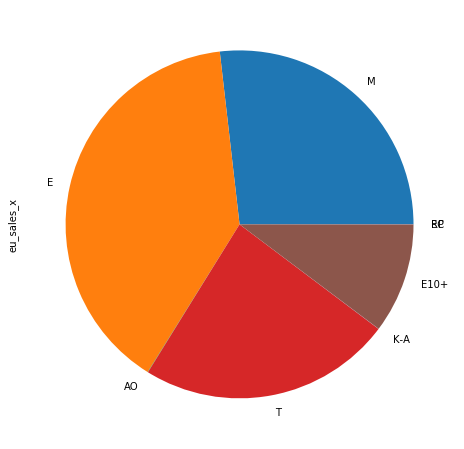

In [77]:
print("ESRB ratings ranked by popularity in EU:")
eu_rating_ranking.plot(
    x = 'rating', y = 'eu_sales_x', kind = 'pie', 
    labels = eu_rating_ranking['rating'], legend = None, figsize = (16,8));
eu_rating_ranking

In [78]:
# create a data set to merge onto

jp_rating_score = pd.DataFrame({'rating': ratings})

# total popularity

jp_sum = rating_sum_score('jp_sales')
jp_median = rating_median_score('jp_sales')

jp_rating_score = jp_rating_score.merge(jp_sum, on= 'rating', how = 'inner')
jp_rating_score = jp_rating_score.merge(jp_median, on= 'rating', how = 'inner')

# drop irrelevant columns

jp_rating_score = jp_rating_score.drop(['jp_sales_y'], axis = 1)

# create total score

jp_rating_score['jp_score'] = (jp_rating_score['sum_score'] + jp_rating_score['median_score'])
jp_rating_ranking = jp_rating_score.sort_values(by = 'jp_score', ascending=False).reset_index(drop = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ESRB ratings ranked by popularity in JP:


,rating,jp_sales_x,sum_score,median_score,jp_score
0,E,197.96,4,3,7
1,E10+,40.20,1,2,3
2,AO,0.00,-1,4,3
3,M,63.58,2,-1,1
4,T,150.70,3,-3,0
5,K-A,1.46,0,0,0
6,EC,0.00,-2,1,-1
7,RP,0.00,-3,-2,-5


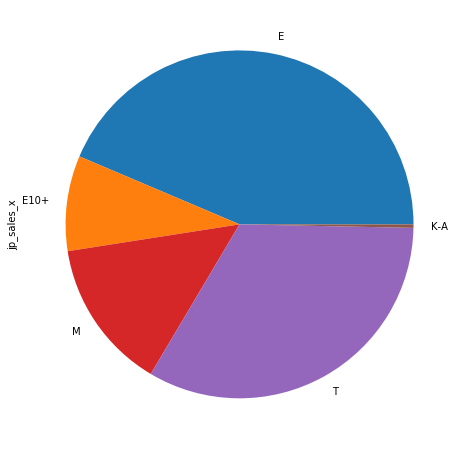

In [79]:
print("ESRB ratings ranked by popularity in JP:")
jp_rating_ranking.plot(
    x = 'rating', y = 'jp_sales_x', kind = 'pie', 
    labels = jp_rating_ranking['rating'], legend = None, figsize = (16,8));
jp_rating_ranking

In [80]:
# create a data set to merge onto

other_rating_score = pd.DataFrame({'rating': ratings})

# total popularity

other_sum = rating_sum_score('other_sales')
other_median = rating_median_score('other_sales')

other_rating_score = other_rating_score.merge(other_sum, on= 'rating', how = 'inner')
other_rating_score = other_rating_score.merge(other_median, on= 'rating', how = 'inner')

# drop irrelevant columns

other_rating_score = other_rating_score.drop(['other_sales_y'], axis = 1)

# create total score

other_rating_score['other_score'] = (other_rating_score['sum_score'] + other_rating_score['median_score'])
other_rating_ranking = other_rating_score.sort_values(by = 'other_score', ascending=False).reset_index(drop = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ESRB ratings ranked by popularity in other regions:


,rating,other_sales_x,sum_score,median_score,other_score
0,M,176.06,3,3,6
1,E,231.54,4,-1,3
2,T,152.99,2,1,3
3,E10+,71.93,1,2,3
4,AO,0.09,-1,4,3
5,EC,0.11,0,0,0
6,K-A,0.03,-2,-3,-5
7,RP,0.01,-3,-2,-5


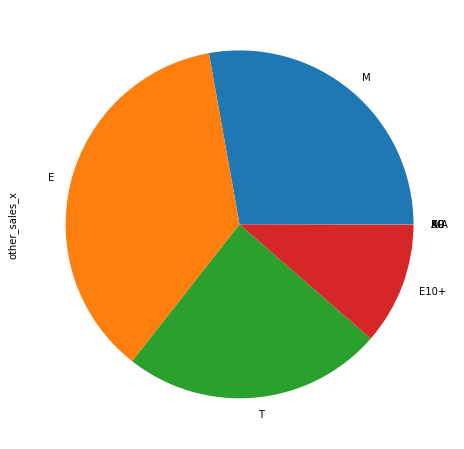

In [81]:
print("ESRB ratings ranked by popularity in other regions:")
other_rating_ranking.plot(
    x = 'rating', y = 'other_sales_x', kind = 'pie', 
    labels = other_rating_ranking['rating'], legend = None, figsize = (16,8));
other_rating_ranking

We get pretty much the same results across all the regions, though Japan is again going against the grain, with T being their most popular genre, as opposed to the other regions' M. despite it being the least popular genre in all other regions. Though while it did rank as the "least popular", it did successfully sell more total titles than E10+ in all regions - just that its median is lower. Though E10+ is the most consistently performing metric, always representing about the same proportion of the sales across all regions.

As before, we will make a bar chart to visualize these rankings.

### Plotted rating popularity rank

In [82]:
full_rating_data = total_rating_ranking.merge(na_rating_ranking, on= 'rating', how = 'inner')
full_rating_data = full_rating_data.merge(eu_rating_ranking, on= 'rating', how = 'inner')
full_rating_data = full_rating_data.merge(jp_rating_ranking, on= 'rating', how = 'inner')
full_rating_data = full_rating_data.merge(other_rating_ranking, on= 'rating', how = 'inner')

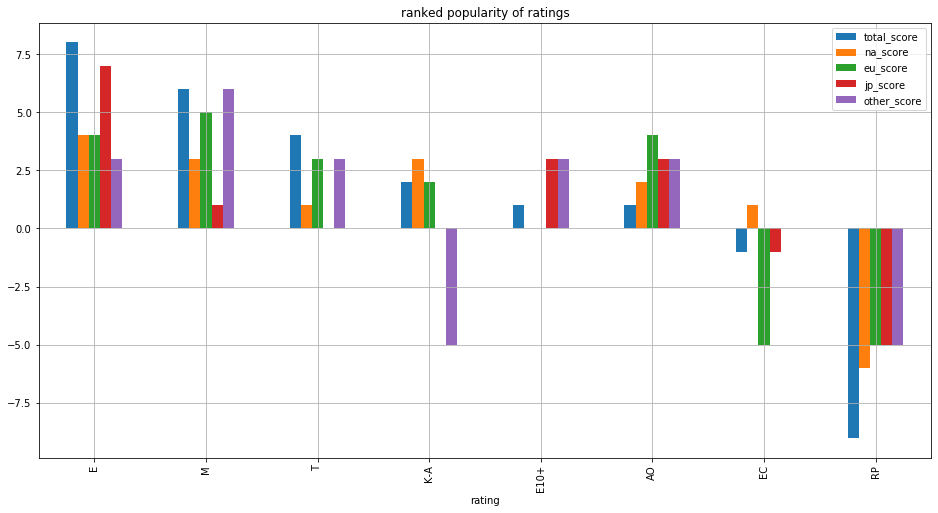

In [83]:
full_rating_data.plot(
    x = 'rating', y = ['total_score', 'na_score', 'eu_score', 'jp_score', 'other_score'], kind = 'bar', 
    title = 'ranked popularity of ratings', grid = True, figsize = (16,8));

## Hypothesis testing

There are two hypotheses that we want to test: that the average user ratings for PC and XBox One are the same, and that the average user ratings for the Action and Sports genre are different. In practice, both of these are actually done in the same way. We will use, for all of these tests, a standard 0.05 level of significance.

### Test PC and XBox One user ratings

$$H_O: UR_{PC} = UR_{XBO}$$

$$H_A: UR_{PC} \neq UR_{XBO}$$

$$\alpha = 0.05$$

In [84]:
# test XBox/PC difference

alpha = 0.05

test_one = st.ttest_ind(scored_games[scored_games['platform'] == 'PC']['user_score'], 
                        scored_games[scored_games['platform'] == 'XOne']['user_score'], 
                        equal_var = False)

print('Mean user score for PC games:', scored_games[scored_games['platform'] == 'PC']['user_score'].mean(), 
      '\nMean user score for XBox One games:', scored_games[scored_games['platform'] == 'XOne']['user_score'].mean(), '\n')

print("P-Value:", test_one.pvalue)
if test_one.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Mean user score for PC games: 7.086104651162791 
Mean user score for XBox One games: 6.606270226537218 

P-Value: 1.5655078086856437e-05
We reject the null hypothesis


We cannot say for certain that the null hypothesis is false. That means that it appears, based on our known data, that the Xbox One and PC's user scores are the same. One thing that might be important to note is that we did modify our data set and made them more similar by filling any values on different skews with the mean of the ones that they are on, but the P-value is significantly greater than our alpha level, so we can feel safe to say it would not have altered our conclusion.

Next we will test to see if the user rating is different for Action and Sports games. Based on some of the things we saw when studying the popularity by genre gives us an indication of what our results will likely be.

### Test Action and Sports user ratings

$$H_O: UR_{Action} = UR_{Sports}$$

$$H_A: UR_{Action} \neq UR_{Sports}$$

$$\alpha = 0.05$$

In [85]:
test_two = st.ttest_ind(scored_games[scored_games['genre'] == 'Action']['user_score'], 
                        scored_games[scored_games['genre'] == 'Sports']['user_score'], 
                        equal_var = False)

print('Mean user score for PC games:', scored_games[scored_games['genre'] == 'Action']['user_score'].mean(), 
      '\nMean user score for XBox One games:', scored_games[scored_games['genre'] == 'Sports']['user_score'].mean(), '\n')

print("P-Value:", test_two.pvalue)
if test_two.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Mean user score for PC games: 7.0282273436440095 
Mean user score for XBox One games: 6.955241358024691 

P-Value: 0.15034462849588667
We fail to reject the null hypothesis


As we might have expected, we reject the null hypothesis. As we saw before, when we calculated the user ratings to determine which genres were the most popular, and Sports had the lowest user reviews. Even though sports games are doing quite well on sales, they are not nearly as popular among the people leaving reviews.

But can we say that the genre is definitively less highly ranked than the Action genre? We can do another hypothesis test to see. If we take the null hypothesis of "Action games do not have a higher user ranking than Sports games" then that hypothesis test would be in the form of the following:

$$H_O: UR_{Action} \leq UR_{Sports}$$

$$H_A: UR_{Action} > UR_{Sports}$$

$$\alpha = 0.05$$

In [86]:
# one-sided t-test

print('Mean user score for PC games:', scored_games[scored_games['genre'] == 'Action']['user_score'].mean(), 
      '\nMean user score for XBox One games:', scored_games[scored_games['genre'] == 'Sports']['user_score'].mean(), '\n')

print("P-Value:", test_two.pvalue / 2)
if (test_two.pvalue / 2 < alpha) & (scored_games[scored_games['genre'] == 'Action']['user_score'].mean() 
                                    > scored_games[scored_games['genre'] == 'Sports']['user_score'].mean()):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Mean user score for PC games: 7.0282273436440095 
Mean user score for XBox One games: 6.955241358024691 

P-Value: 0.07517231424794334
We fail to reject the null hypothesis


Our one-sided t-test verifies that we cannot reject the null hypothesis and that, yes, there is a statistically significant difference that allows us to say that action games appear to have higher user ranking than sports games.

## Platform life

This topic is used to determine what could be expected in coming years based on the historical life of a platform. It involves taking two factors into consideration, both of which can be found via bar charts: how long platforms have historically lasted, and how the current platforms are doing. In this point, we will simply be measuring the number of new games being released on each platform.

A simple way to gather our data to find this is to make a grouped plot. Since our 3 years of data is rather limited, we will plot the full data set.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


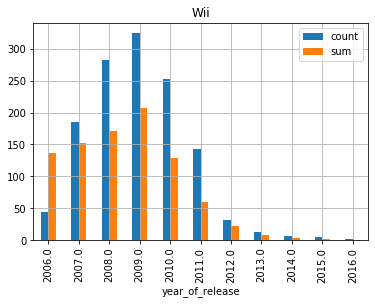

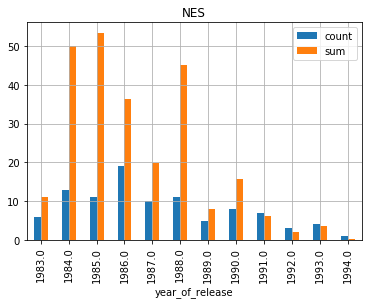

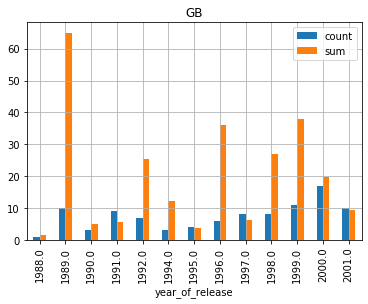

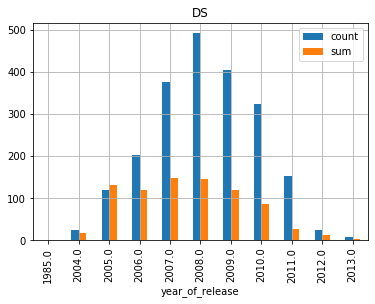

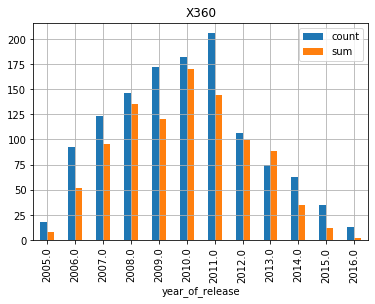

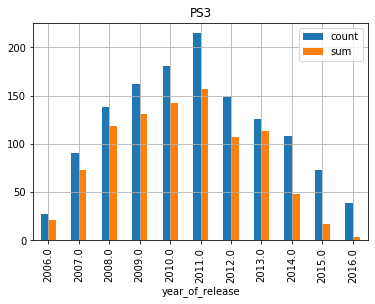

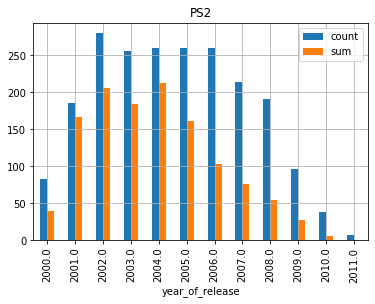

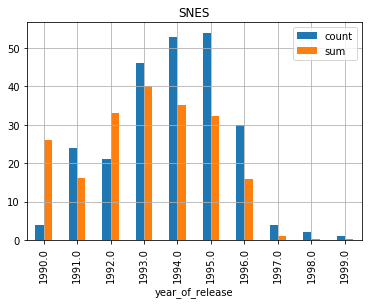

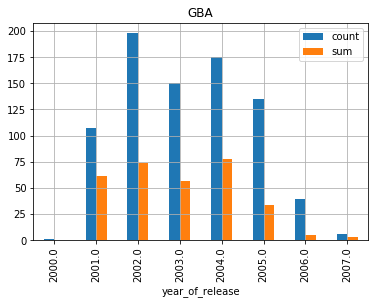

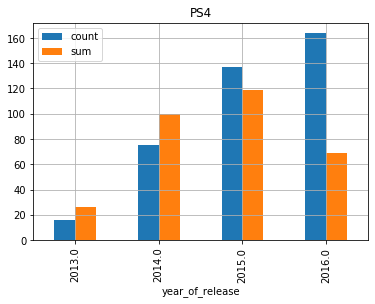

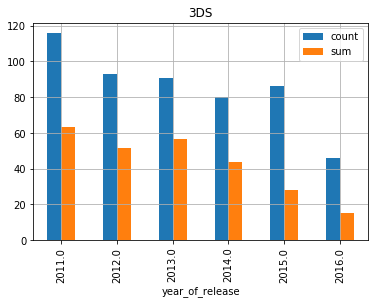

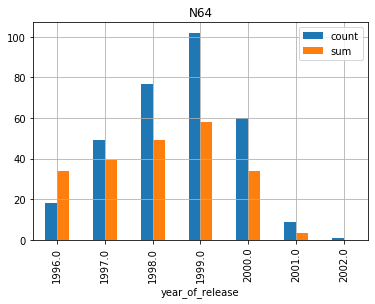

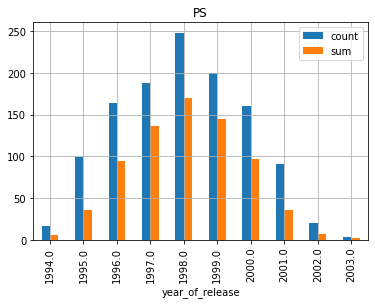

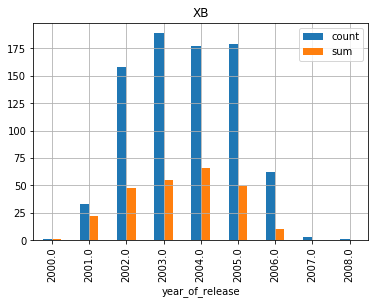

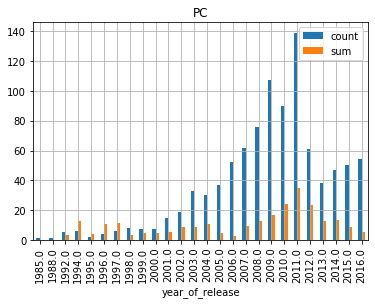

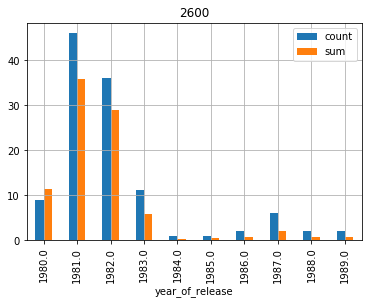

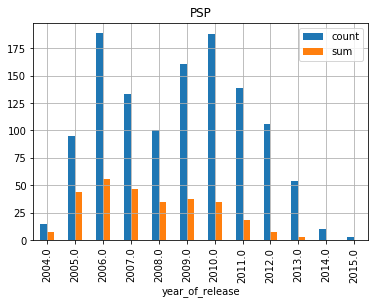

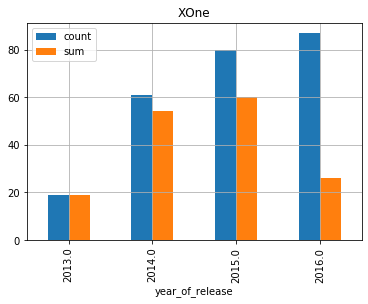

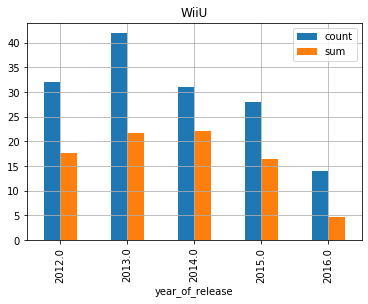

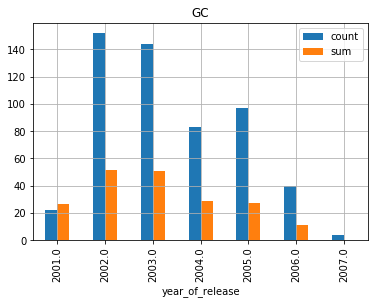

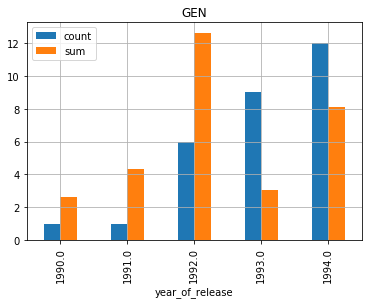

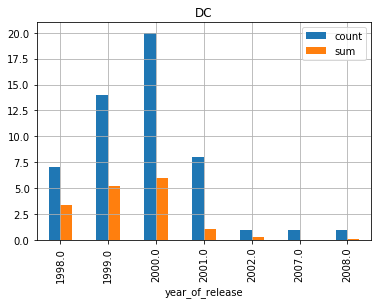

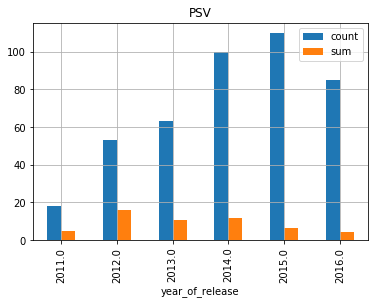

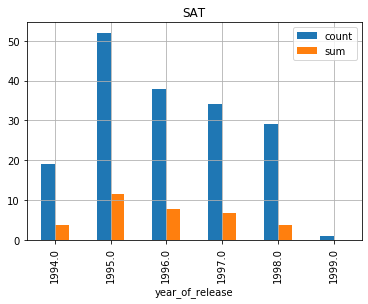

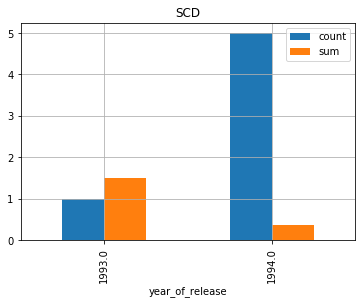

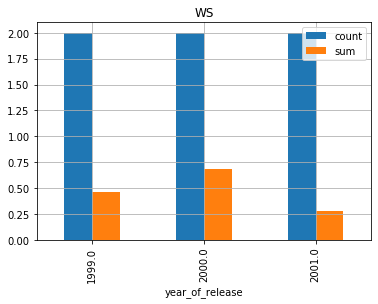

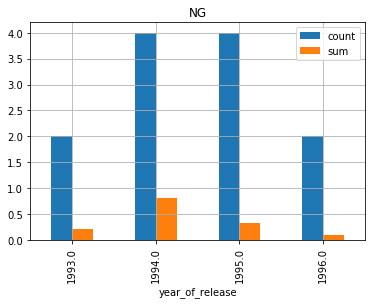

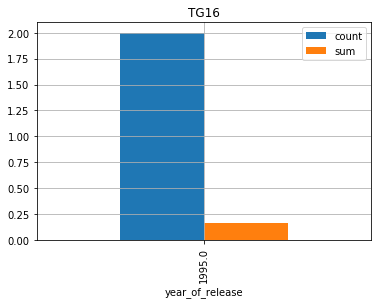

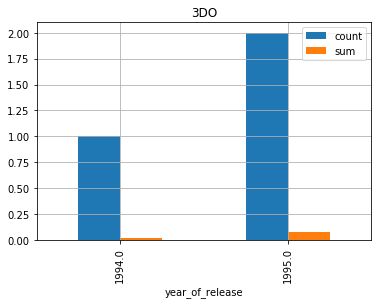

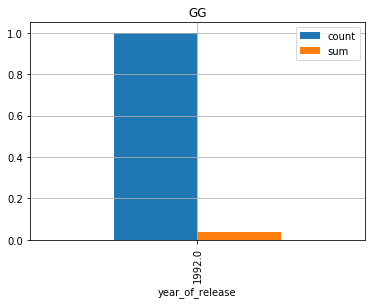

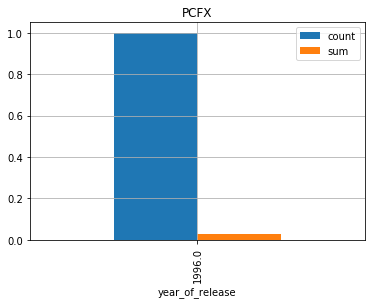

In [87]:
# plot all platform performance by year

full_grouped_games = games_no_miss.groupby(['platform','year_of_release']).agg({'total_sales' : ('count','sum')}).reset_index()
full_consoles = games_no_miss['platform'].unique()

for console in full_consoles:
    full_grouped_games[full_grouped_games['platform'] == console].plot(x = 'year_of_release', y = 'total_sales', title = console,
                                                             kind = 'bar', grid = True)

We see a few things here. We can safely say that until the gaming industry really stabilized, there wasn't much consistency in a console's lifespan. We see some patterns once we get to the mid 90s, with those consoles lasting about 4 or 5 years of consistent releases followed by a swift transition into a new machine (notice how the Game Boy had a steady flow that we don't see dip to zero, but rather it stops at 2001 and the GBA immediately picks up with a large library.

But of consoles that do show normal distributions of their game releases, they seem to mostly last around 4-6 years of growth followed by about 4-6 years of decline, with both being approximately equal length. Some see longer lifespans, or shorter lifespans, but that is a general pattern.

This makes sense when we consider that, since the sixth generation, many consoles have attempted to organically upgrade by releasing some games on both generations simultaneously and still supporting the previous console but slowly moving to the new one. It is a distinctly different business model from older generations where support would basically die off at an arbitrary point (as we see in cases like the Genesis and the SNES, where their release of games suddenly and abruptly drops).

Modern Nintendo consoles do not follow this pattern, their lifespans as seen in the data tend to be shorter. However, that also could mean that they are more likely to have an audience move to their new console, as they do not generally engage in the same practice as Sony and Microsoft where they have as many releases across both skews. It also seems that Nintendo tends to release more machines across shorter periods. For example: the PSP was receiving active support from 2004-2013, with the PS Vita taking precedence as the main Sony Handheld at 2011, whereas in that same time period, Nintendo had moved from the GBA in 2001 which was actively receiving support through 2005, releasing the DS in 2004 and the 3DS in 2011.

In the past, consoles were far more hectic, but the industry stabilizing means we can say that in general, we can expect a console lifespan of approximately 8-10 years, depending heavily on how the successor console 

## How reviews influence sales

We previously got a look at a scatter plot that showed how reviews and sales are correlated. We will dive deeper here, to see just how closely the two are correlated.

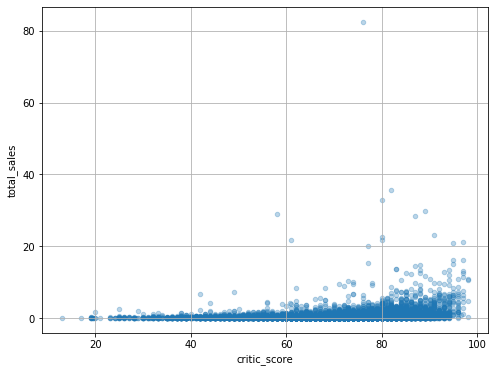

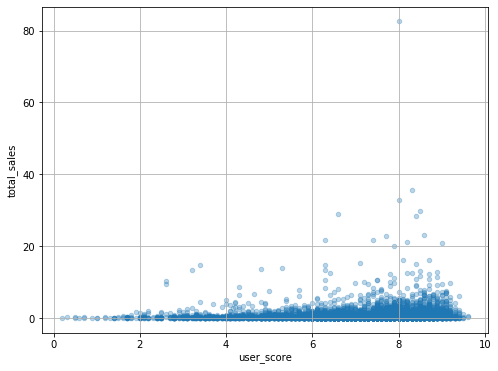

In [88]:
# scatter plot

scored_games.plot(x='critic_score', y='total_sales', kind='scatter', figsize=(8, 6), alpha=0.3, grid=True);

scored_games.plot(x='user_score', y='total_sales', kind='scatter', figsize=(8, 6), alpha=0.3, grid=True);

While we earlier established that there is a moderate correlation between sales and critic score, but almost no correlation between the sales and the user score.

It may not be safe to assume that scores are a predictor of sales - after all, if a game is selling well then it will receive more attention and have more critics and users reviewing it, in general. Meanwhile, critics might have completely overlooked the lower scoring games that users reviewed out of a personal reason. A critic might be expected, or even required, to give certain games a more favorable score than a user.

It could be that critics are less likely to review a game that does not sell as well, or that they are more likely to give a high-selling game a good review than the users are. We should take a closer look at where most of our data is clustered, to see if that provides us some additional insight.

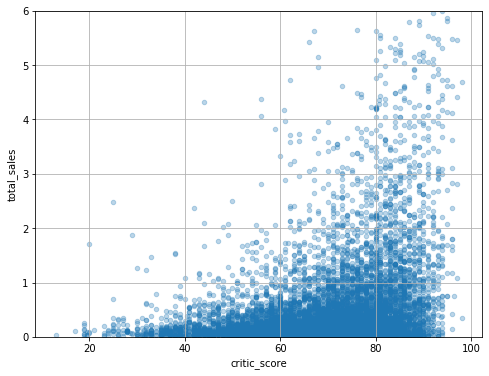

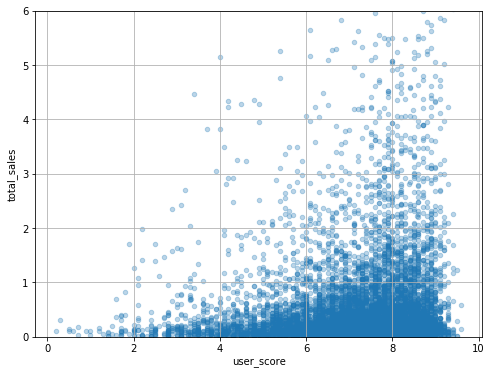

In [89]:
# zoomed in plot

scored_games.plot(x='critic_score', y='total_sales', kind='scatter', figsize=(8, 6), ylim = (0,6), alpha=0.3, grid=True);

scored_games.plot(x='user_score', y='total_sales', kind='scatter', figsize=(8, 6), ylim = (0,6), alpha=0.3, grid=True);

We do see that weak correlation with the user score and the games starting to take effect. As a whole, it seems that sales do have a correlation with a user score, but there also are many high-selling games that have a low user score that throws off the correlation coefficient. When we consider earlier that, for example, users rate sports games as the lowest genre, combined with the knowledge that sports is the fourth most common genre of game.

We will also see how the sales correlate based on region and see if there are any interesting differences.

North America:


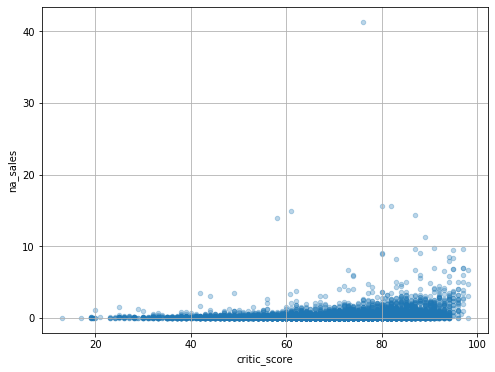

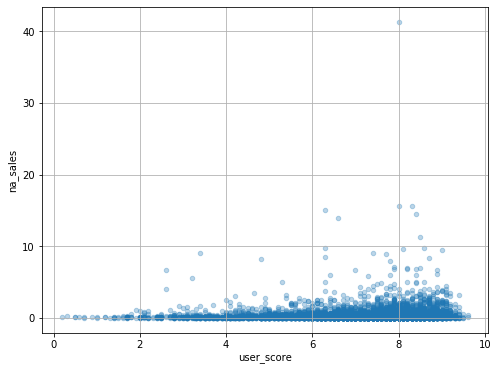

In [90]:
# North America

print("North America:")

scored_games.plot(x='critic_score', y='na_sales', kind='scatter', figsize=(8, 6), alpha=0.3, grid=True);

scored_games.plot(x='user_score', y='na_sales', kind='scatter', figsize=(8, 6), alpha=0.3, grid=True);

Europe:


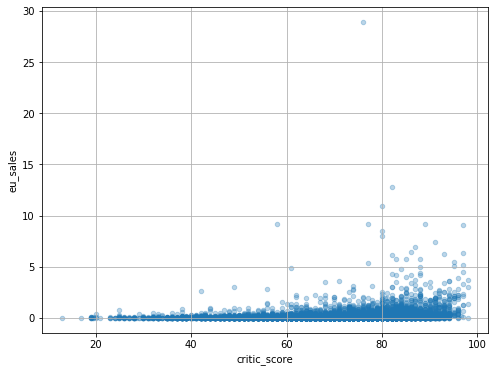

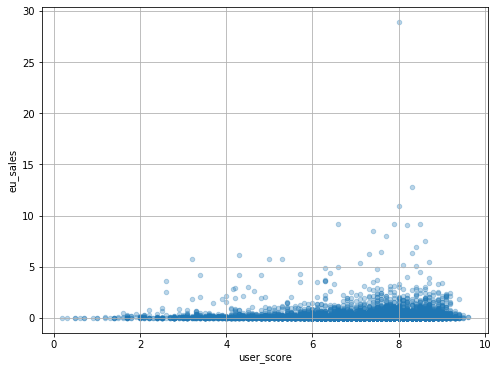

In [91]:
# Europe

print("Europe:")
scored_games.plot(x='critic_score', y='eu_sales', kind='scatter', figsize=(8, 6), alpha=0.3, grid=True);

scored_games.plot(x='user_score', y='eu_sales', kind='scatter', figsize=(8, 6), alpha=0.3, grid=True);

Japan:


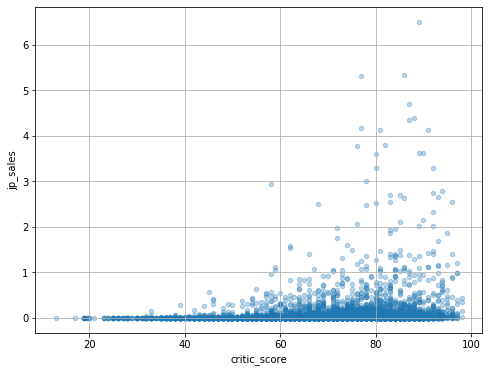

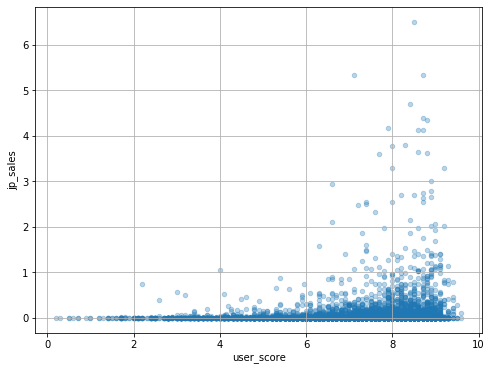

In [92]:
# Japan

print("Japan:")

scored_games.plot(x='critic_score', y='jp_sales', kind='scatter', figsize=(8, 6), alpha=0.3, grid=True);

scored_games.plot(x='user_score', y='jp_sales', kind='scatter', figsize=(8, 6), alpha=0.3, grid=True);

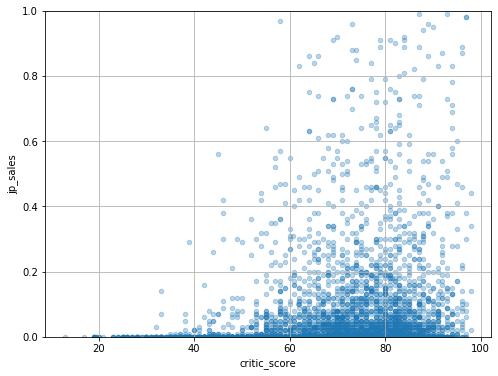

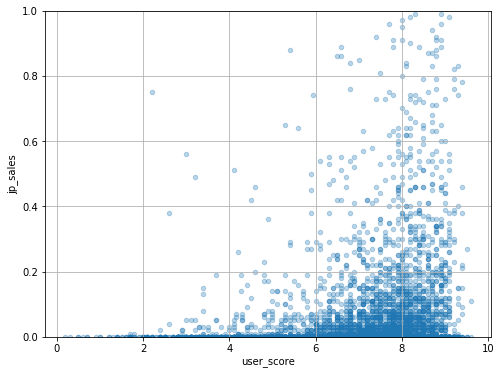

In [93]:
# zoomed in plot

scored_games.plot(x='critic_score', y='jp_sales', kind='scatter', figsize=(8, 6), ylim = (0,1), alpha=0.3, grid=True);

scored_games.plot(x='user_score', y='jp_sales', kind='scatter', figsize=(8, 6),ylim = (0,1), alpha=0.3, grid=True);

Other regions:


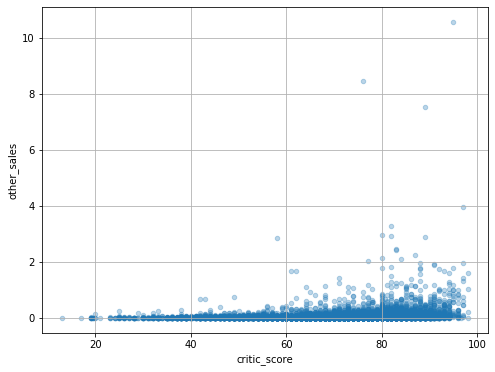

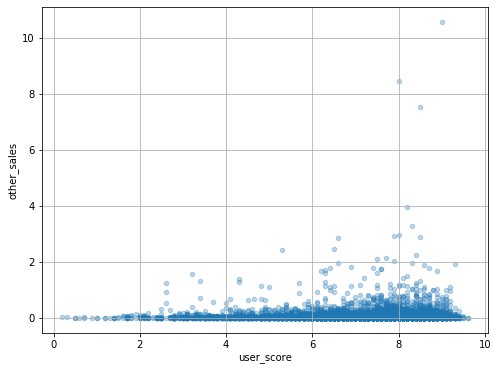

In [94]:
# Other

print("Other regions:")

scored_games.plot(x='critic_score', y='other_sales', kind='scatter', figsize=(8, 6), alpha=0.3, grid=True);

scored_games.plot(x='user_score', y='other_sales', kind='scatter', figsize=(8, 6), alpha=0.3, grid=True);

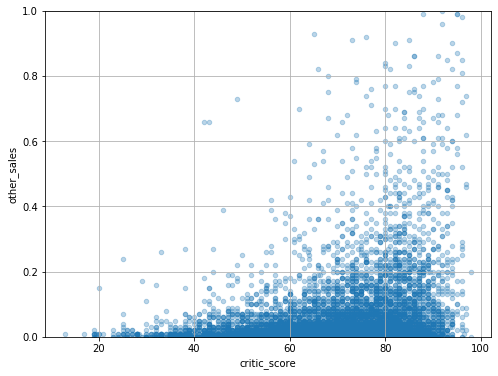

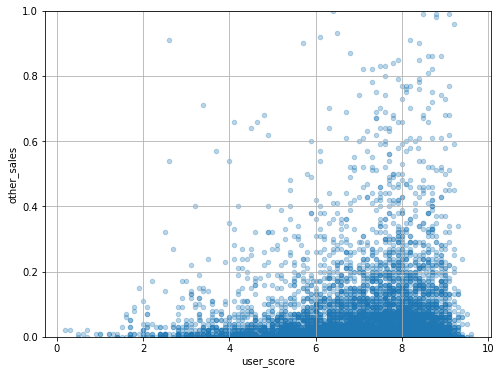

In [95]:
# zoomed in plot

scored_games.plot(x='critic_score', y='other_sales', kind='scatter', figsize=(8, 6), ylim = (0,1), alpha=0.3, grid=True);

scored_games.plot(x='user_score', y='other_sales', kind='scatter', figsize=(8, 6), ylim = (0,1), alpha=0.3, grid=True);

Overall it seems that the ratings and sales have similar traits regardless of the region. As we have seen demonstrated throughout, we do notice that Japan's scatter plot is quite different, with very few titles as a whole surpassing \\$1,000,000 in sales.

## Game sales across different skews



In order to make a determination of how games sell across different skews, we only are going to be interested in seeing a subset of our data, for games that have their title appearing more than once. We should be able to get a good idea of how the sales look by checking a box plot.

In [96]:
# create a data frame of duplicated games

dupe_games = games[games['name'].duplicated(keep = False)]

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


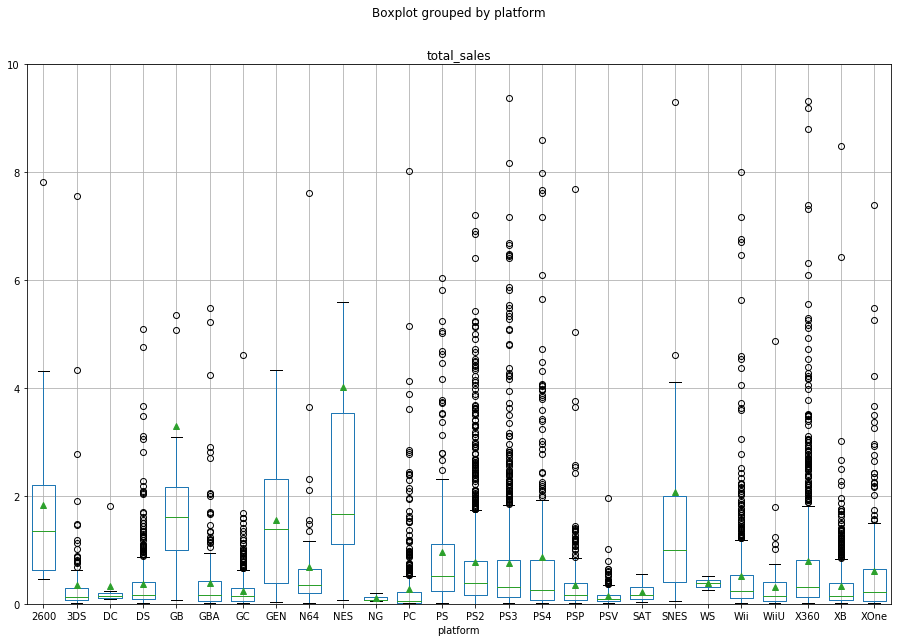

In [97]:
dupe_games.boxplot(column = 'total_sales', by = 'platform', showmeans = True, figsize = (15,10), widths = 0.7);
plt.ylim([0,10]);

In this case, we can consider some consoles to have what might be described as "hardware exclusivity" that is partially the reason for their box plots to look this way. The handheld systems, Wii and Wii U are all running on a different type of hardware than the home consoles and PC, which is why their box plots are so much smaller. Most of the games released on them could be described as being entirely different games from the console versions.

If a game needs to be constructed for a significantly different piece of hardware. Given our data frame, we can safely state that the 3DS, DS, PSP, PS Vita, Wii and Wii U are all too different from not only the standard home console but also each other that they should not be accounted for in this analysis.

In [98]:
similar_consoles = dupe_games.query(
    'platform == "PS3" or platform == "PS4" or platform == "X360" or platform == "XOne" or platform == "PC"')
similar_consoles

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
29,Call of Duty: Modern Warfare 3,X360,2011.0,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
32,Call of Duty: Black Ops,X360,2010.0,Shooter,9.70,3.68,0.11,1.13,87.0,6.3,M,14.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16672,Metal Gear Solid V: The Definitive Experience,XOne,2016.0,Action,0.01,0.00,0.00,0.00,78.0,7.8,M,0.01
16690,Pony Friends 2,PC,2009.0,Simulation,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16691,Dynasty Warriors: Eiketsuden,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16692,Metal Gear Solid V: Ground Zeroes,PC,2014.0,Action,0.00,0.01,0.00,0.00,80.0,7.6,M,0.01


By removing some of the consoles, we might have ended up no longer having games across multiple skews represented. For instance, if a title was released only on PS4 and 3DS, it would no longer be possible for us to measure its performance across different platforms after removing the 3DS values. Thus, we should remove any of the non-duplicate titles once more.

In [99]:
similar_consoles = similar_consoles[similar_consoles['name'].duplicated(keep = False)]

In [100]:
# descriptive statistics

print("Variance of sales by platform:\n", similar_consoles.groupby(['platform'])['total_sales'].var(),
      "\n\nTotal sales by platform:")
similar_consoles.groupby(['platform'])['total_sales'].describe()

Variance of sales by platform:
 platform
PC      0.338319
PS3     2.300039
PS4     3.145494
X360    2.449314
XOne    1.017963
Name: total_sales, dtype: float64 

Total sales by platform:


,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
PC,426.0,0.240000,0.581652,0.01,0.020,0.07,0.22,8.01
PS3,917.0,0.809084,1.516588,0.01,0.150,0.38,0.87,21.05
PS4,289.0,0.961488,1.773554,0.01,0.080,0.33,0.92,14.63
X360,905.0,0.852983,1.565029,0.01,0.150,0.37,0.89,16.27
XOne,223.0,0.604709,1.008941,0.01,0.055,0.22,0.65,7.39


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


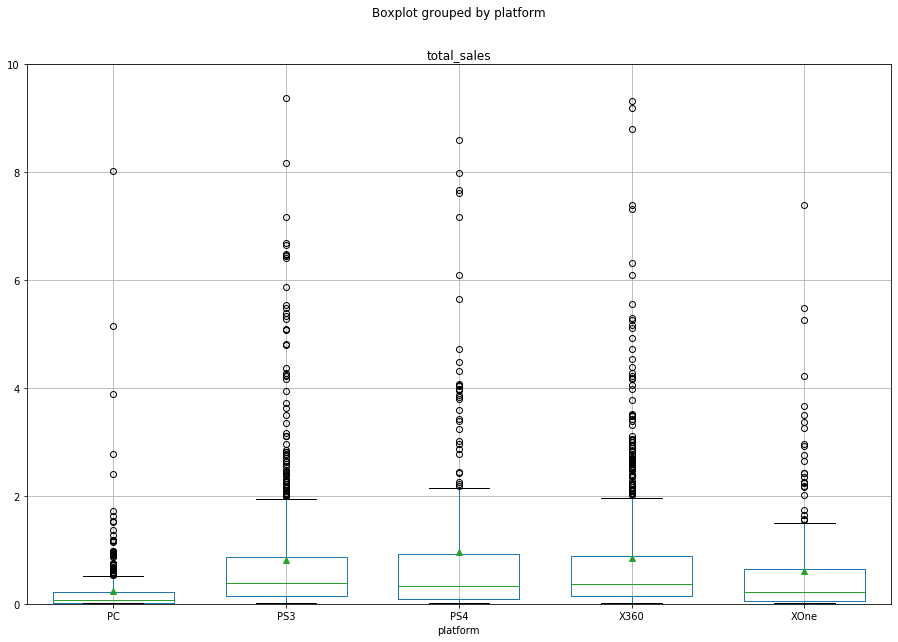

In [101]:
similar_consoles.boxplot(column = 'total_sales', by = 'platform', showmeans = True, figsize = (15,10), widths = 0.7);
plt.ylim([0,10]);

For games that are released on multiple platforms, the PC clearly is performing the worst. Between the PS3 and the 360, it seems that the games sell better on the 360, but the PS4 is doing better than the XBox One.

Their means, medians, standard deviations, and variance actually appear to stabilize, with the two consoles with the highest number of titles represented (the PS3 and 360) having the most similarity between each other. This could be a good reason to do some more hypothesis testing.

### Hypothesis tests

We should do another t-test to see if this is the case. While we test the seventh generation consoles, we also might wish to perform a hypothesis test on the eighth generation consoles, as well.

$$H_O: Sales_{PS3} = Sales_{360}$$
$$H_A: Sales_{PS3} \neq Sales_{360}$$
$$\alpha = 0.05$$

In [102]:
test_four = st.ttest_ind(similar_consoles[similar_consoles['platform'] == 'PS3']['total_sales'], 
                        similar_consoles[similar_consoles['platform'] == 'X360']['total_sales'], 
                        equal_var = False)

print('Mean sales for PS3 games:', similar_consoles[similar_consoles['platform'] == 'PS3']['total_sales'].mean(), 
      '\nMean sales for XBox 360 games:', similar_consoles[similar_consoles['platform'] == 'X360']['total_sales'].mean(),
      '\n')

print("P-Value:", test_four.pvalue)
if test_four.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Mean sales for PS3 games: 0.8090839694656488 
Mean sales for XBox 360 games: 0.8529834254143647 

P-Value: 0.543316269837054
We fail to reject the null hypothesis


$$H_O: Sales_{PS4} = Sales_{XB1}$$
$$H_A: Sales_{PS4} \neq Sales_{XB1}$$
$$\alpha = 0.05$$

In [103]:
test_five = st.ttest_ind(similar_consoles[similar_consoles['platform'] == 'PS4']['total_sales'], 
                        similar_consoles[similar_consoles['platform'] == 'XOne']['total_sales'], 
                        equal_var = False)

print('Mean sales for PS4 games:', similar_consoles[similar_consoles['platform'] == 'PS4']['total_sales'].mean(), 
      '\nMean sales for XBox One games:', similar_consoles[similar_consoles['platform'] == 'XOne']['total_sales'].mean(),
      '\n')

print("P-Value:", test_five.pvalue)
if test_five.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Mean sales for PS4 games: 0.9614878892733566 
Mean sales for XBox One games: 0.6047085201793722 

P-Value: 0.004282778437727833
We reject the null hypothesis


We failed to reject the null hypothesis for the previous generation consoles, so that says that the sales are not significantly different between the two primary consoles of the seventh generation. On the other hand, for the current generation consoles we do reject the null hypothesis. It suggests that, at least at the moment, the PS4 is performing differently than the XBox One.

We should also do some tests to see if performance is the same across one generation to the next. We will do one-sided t-tests to see if the new console games are selling better.

$$H_O: Sales_{PS3} \geq Sales_{PS4}$$
$$H_A: Sales_{PS3} < Sales_{PS4}$$
$$\alpha = 0.05$$

In [104]:
test_six = st.ttest_ind(similar_consoles[similar_consoles['platform'] == 'PS3']['total_sales'], 
                        similar_consoles[similar_consoles['platform'] == 'PS4']['total_sales'], 
                        equal_var = False)

print('Mean sales for PS3 games:', similar_consoles[similar_consoles['platform'] == 'PS3']['total_sales'].mean(), 
      '\nMean sales for PS4 games:', similar_consoles[similar_consoles['platform'] == 'PS4']['total_sales'].mean(),
      '\n')

print("P-Value:", test_six.pvalue / 2)
if ((test_six.pvalue /2) < alpha) & ((similar_consoles[similar_consoles['platform'] == 'PS3']['total_sales'].mean() 
                                    < similar_consoles[similar_consoles['platform'] == 'PS4']['total_sales'].mean())):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Mean sales for PS3 games: 0.8090839694656488 
Mean sales for PS4 games: 0.9614878892733566 

P-Value: 0.09427954932452137
We fail to reject the null hypothesis


$$H_O: Sales_{360} \geq Sales_{XB1}$$
$$H_A: Sales_{360} < Sales_{XB1}$$
$$\alpha = 0.05$$

In [105]:
test_seven = st.ttest_ind(similar_consoles[similar_consoles['platform'] == 'X360']['total_sales'], 
                        similar_consoles[similar_consoles['platform'] == 'XOne']['total_sales'], 
                        equal_var = False)

print('Mean sales for Xbox 360 games:', similar_consoles[similar_consoles['platform'] == 'X360']['total_sales'].mean(), 
      '\nMean sales for XBox One games:', similar_consoles[similar_consoles['platform'] == 'XOne']['total_sales'].mean(),
      '\n')

print("P-Value:", test_seven.pvalue)
if ((test_seven.pvalue /2) < alpha) & ((similar_consoles[similar_consoles['platform'] == 'X360']['total_sales'].mean() 
                                    < similar_consoles[similar_consoles['platform'] == 'XOne']['total_sales'].mean())):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Mean sales for Xbox 360 games: 0.8529834254143647 
Mean sales for XBox One games: 0.6047085201793722 

P-Value: 0.003750971097171401
We fail to reject the null hypothesis


We see that the sales for the PS3 games are selling wore than the PS4 games, but we cannot say for certain that the XBox 360 games are selling worse than XBox One games.

The ultimate conclusion that we can draw from this is that unless a game is using the same name but is a significantly different game, it appears that it does not matter which system it is released on. What this means for policy is that Microsoft probably could not do much harm giving one more year of support for the 360, but Sony is ready to move into their new console. Though in all cases, we see that the next console generation is growing.

## Overall conclusions

To summarize everything we have done here: first, we manipulated the data set to cover the past 3 years, dropping consoles that were sufficiently old, and checking to see the number of entries with a missing year entry. Since there were not many with a missing year that could be filled in outside of doing it manually, we decided to drop them as well. We filled in missing values in the user and critic scores by checking how the two correlated to one another and using the other to fill in, where possible.

* We checked the popularity of different consoles, genres, and ESRB ratings, both overall and by region.

* We performed hypothesis tests on the difference between PC and XBox One user ratings and the Action and Sports genre.

* We studied patterns in the average lifespan of different consoles, both in our current generation and in previous ones.

* We plotted data to examine how reviews and sales might interact.

* We checked how games sell across different skews.

Overall, it would appear that the plan for increasing sales in 2017 is in a bit of an uncertain state. We are at the end of one console generation and approaching the peak years of a different one, so the data we have seen over the past few years does appear slightly misleading if we take it at face value. If we are presented with specific policy-related questions, the analysis has sufficiently prepared us to answer them. For a few examples:

* If a company is unsure if they want to begin producing games for the eighth generation consoles, since they only have the budget to make a game across two skews, we could tell them that the newer consoles are reaching their peak years and that it would be a good time to make the move.

* If a company is considering releasing a new fighting game, releasing it in Japan first would be a good idea to maximize efficiency, as the genre is doing better in Japan.

* If a company has a game nearing finalization stages that contains slightly too much explicit content and is given a T rating that they want to sell well in all regions, it might be worthwhile to consider modifying the content, since E10+ rated games have more

Those sort of problems and others are addressed with this analysis.